# Investigating periods of increasing interest rates for the S&P 1500
### by Luca Reichelt, 999786

## 1. Outline

This project aims to investigate periods of increasing interest rates by the federal reserve based on the constituents of the S&P 1500. As an end result we attempt to implement our findings into a portfolio strategy.

The first month of observation is defined as the month of the first hike. The last date of observation is defined as the last month before a decreasing or stagnant interest rate (no change). Company data is based on the latest data available which have been published before the first day.
We do not adjust for changes in the SP1500, but will include all the data available for its constituents as of the first month of the respective period.

All of the data that isn't retrieved while executing the code has been exported from Bloomberg Terminal or investing.com and is available within the folder "data_raw" in xlsx format. The data which is retrieved during the code execution is retrieved from Yahoo Finance or the FRED API, which is a API provided by the Federal Reserve of St.Lewis (https://fred.stlouisfed.org/docs/api/fred/).

You should be able to run this notebook after creating a local environment using anconda/miniconda and executing following command while referring to the provided yaml file:

`conda env create --file=env.yaml`

## 2. Data

In [1]:
# importing the main packages
from datetime import datetime
# import dateutil.parser
import os
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None
import yfinance as yf
import pandas_datareader.data as web
import pickle as pkl
import dataframe_image as dfi

### 2.1 Data Retrieval

In [2]:
# getting the last periods of increasing interest rates (Federal Funds Effective MONTHLY Rate) from 1965 onwards
fed_rates = web.DataReader("FEDFUNDS", "fred", 1965)
fed_rates.set_index(pd.to_datetime(fed_rates.index.date), inplace=True)

# test for empty values
print(fed_rates.index.isna().sum())

0


In [35]:
def period_df(start, duration, fed_rates=fed_rates):
    fed_rates = fed_rates[fed_rates.index >= start]

    df = pd.DataFrame(columns=["Name", "Start", "Last"])
    df.loc[df.shape[0]] = [None, None, None]

    df.is_copy = False

    period = 0
    j = 0

    for i in range(0, len(fed_rates) - 1):
        if (fed_rates.iloc[i + 1]["FEDFUNDS"] <= fed_rates.iloc[i]["FEDFUNDS"]) and (
            i - j >= duration
        ):
            df.loc[period, "Last"] = datetime.strftime(fed_rates.index[i], "%Y-%m-%d")
            period += 1
            if (fed_rates.index[-1] - fed_rates.index[i]).days >= 365:
                df.loc[len(df)] = [None, None, None]
                j = i
        elif (fed_rates.iloc[i + 1]["FEDFUNDS"] <= fed_rates.iloc[i]["FEDFUNDS"]) and (
            i - j < duration
        ):
            df.loc[period, "Name"] = "Period " + str(period + 1)
            df.loc[period, "Start"] = datetime.strftime(fed_rates.index[i], "%Y-%m-%d")
            j = i

    # add last date
    df.loc[period, "Last"] = "2023-04-01"

    # add duration column
    df["Duration"] = (
        round(
            (pd.to_datetime(df["Last"]) - pd.to_datetime(df["Start"]))
            / np.timedelta64(1, "M")
        )
    ).astype(int)

    # export df as image
    dfi.export(
        df.style.set_properties(
            **{"background-color": "white", "color": "black", "border-color": "#948b8b"}
        ),
        "periods" + start + ".png",
    )
    # df["Start"] = pd.to_datetime(df["Start"])
    # df["Last"] = pd.to_datetime(df["Last"])
    return df


period_df(start="1965", duration=12)
# unfortunately lack of data regarding constituents for this period from bloomberg

periods = period_df(start="1995", duration=9)

In [4]:
def web_import(rate, start, end):
    df = web.DataReader(rate, "fred", start, end)
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)
    return df

In [5]:
# def yf_import(ticker, start, end):
#     data = yf.download(ticker, start, end)
#     monthly = data.groupby(pd.PeriodIndex(data.index, freq="M"))["Close"].mean()
#     print(monthly)
#     if data.size > 0:
#         if (
#             not data.empty == True
#             and len(monthly.values)
#             == round((data.index[-1] - data.index[0]) / np.timedelta64(1, "M"))
#             and len(monthly.values) >= 9
#         ):
#             df = pd.DataFrame(
#                 index=pd.date_range(start, end, freq="MS"),
#                 data=np.append(monthly.values, data.iloc[-1]["Close"]),
#             )
#             df.rename(columns={df.columns[0]: ticker}, inplace=True)
#             df.drop(columns=df.columns.difference([ticker]), inplace=True)
#             df.index = pd.to_datetime(df.index)
#             return df
#         elif len(monthly.values) < 9:
#             empty = np.empty((1, 11 - (len(monthly))))
#             empty[:] = np.nan
#             df_data = np.append(empty, monthly.values)
#             df = pd.DataFrame(index=pd.date_range(start, end, freq="MS"), data=df_data)
#             df.rename(columns={df.columns[0]: ticker}, inplace=True)
#             df.drop(columns=df.columns.difference([ticker]), inplace=True)
#             df.index = pd.to_datetime(df.index)
#             return df
#     else:
#         df = pd.DataFrame(index=pd.date_range(start, end, freq="MS"), columns=[ticker])
#         df.index = pd.to_datetime(df.index)
#         return df

# above is overkill

def yf_import(ticker, start, end):
    data = yf.download(ticker, start, end)
    monthly = data.groupby(pd.PeriodIndex(data.index, freq="M"))["Close"].mean()
    monthly.index = monthly.index.to_timestamp()
    df = pd.DataFrame(index=pd.date_range(start, end, freq="MS"))
    df.index = pd.to_datetime(df.index)
    df.insert(0, ticker, monthly)
    return df

In [6]:
raw = "data_raw/"

gold = pd.read_csv(raw + "Gold_Futures.csv").set_index("Date")
gold["Gold"] = gold["Price"].str.replace(",", "").astype(float)
gold.drop(columns=gold.columns.difference(["Gold"]), inplace=True)
gold.index = pd.to_datetime(gold.index)
gold.sort_index(inplace=True)

### 2.2 Introductory Visualizations

In [7]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

tickers = ["^SP1500", "^IXIC"]
rates = ["FEDFUNDS", "CORESTICKM159SFRBATL", "UNRATE"]


def comparison(tickers, start, end):
    df = gold.loc[start:end]
    for ticker in tickers:
        df = pd.concat([df, yf_import(ticker, start, end)], axis=1)
    df = pd.concat([df, web.DataReader("WTISPLC", "fred", start, end)], axis=1)
    df_chg = df.pct_change() * 100

    legend = {
        "Gold": "Gold",
        "^SP1500": "S&P 1500",
        "^IXIC": "Nasdaq",
        "WTISPLC": "Spot Crude Oil Price WTI",
        "FEDFUNDS": "FED Rate",
        "CORESTICKM159SFRBATL": "CPI",
        "UNRATE": "Rate of Unemployment",
    }

    fig = px.line(
        df_chg,
        # ["Gold", "^SP1500", "^IXIC", "WTISPLC"],
        labels=legend,
        title="Indices/Assets monthly change in %",
    )
    fig.update_yaxes(title="Change in % compared to month before")
    fig.update_xaxes(title="Date")
    fig.for_each_trace(
        lambda t: t.update(
            name=legend[t.name],
            legendgroup=legend[t.name],
            hovertemplate=t.hovertemplate.replace(t.name, legend[t.name]),
        )
    )

    for index, row in periods.iterrows():
        fig.add_vline(
            x=row["Start"], line_width=2, line_dash="dash", line_color="green"
        )
        fig.add_vline(x=row["Last"], line_width=2, line_dash="dash", line_color="red")

    fig.update_layout(legend_title="Legend", autosize=False, width=1200, height=600)
    fig.show()

    df_perf = df.apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100))

    for rate in rates:
        df_perf = pd.concat([df_perf, web.DataReader(rate, "fred", start, end)], axis=1)

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    x = df_perf.index

    for ticker in tickers:
        fig.add_trace(
            go.Scatter(x=x, y=df_perf[ticker], name=legend[ticker]),
            secondary_y=False,
        )

    fig.add_trace(
        go.Scatter(x=x, y=df_perf["Gold"], name="Gold"),
        secondary_y=False,
    )

    fig.add_trace(
        go.Scatter(x=x, y=df_perf["WTISPLC"], name="Spot Crude Oil Price WTI"),
        secondary_y=False,
    )

    for rate in rates:
        fig.add_trace(
            go.Scatter(x=x, y=df_perf[rate], name=legend[rate]),
            secondary_y=True,
        )

    for index, row in periods.iterrows():
        fig.add_vline(
            x=row["Start"], line_width=2, line_dash="dash", line_color="green"
        )
        fig.add_vline(x=row["Last"], line_width=2, line_dash="dash", line_color="red")

    fig.update_yaxes(title_text="Total Indices/Asset change in %", secondary_y=False)
    fig.update_yaxes(title_text="Rates for FED/CPI/Unemployment", secondary_y=True)

    fig.update_xaxes(title="Date")

    fig.update_layout(
        title="Total performance to FED/CPI/Unemployment Rate",
        legend_title="Legend",
        autosize=False,
        width=1200,
        height=600,
    )
    fig.show()

In [8]:
comparison(
    tickers,
    periods.iloc[0]["Start"],
    periods.iloc[-1]["Last"],
)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### 2.3 Pre-Processing the features data
#### This data has been retrieved beforehand via the Bloomberg Excel Add-ins and is imported from the files in data-raw

In [9]:
# the periods refer to the four timeframes from the outline

period_data = [
    "SPR_Period_1.xlsx",
    "SPR_Period_2.xlsx",
    "SPR_Period_3.xlsx",
    "SPR_Period_4.xlsx",
]

In [10]:
def scatterplots(df):
    fig = px.scatter(
        df,
        x="Beta:M-1",
        y="Market Cap_perf",
        size="Market Cap",
        title="Risk/Compared Volatility to SP1500 compared to Return/Performance for single companies",
        color="GICS Sector",
        hover_name="Name",
        log_x=True,
        size_max=100,
        width=1200,
        height=600,
    )

    fig.show()

    grouped = df.drop(columns=["Name"]).groupby("GICS Sector").mean()

    fig = px.scatter(
        grouped,
        x="Beta:M-1",
        y="Market Cap_perf",
        size="Market Cap",
        title="Risk/Compared Volatility to SP1500 compared to Return/Performance by GICS Sector",
        color="Market Cap_perf",
        hover_name=grouped.index,
        log_x=True,
        size_max=100,
        width=1200,
        height=600,
    )

    fig.show()

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

def heatmap(df):
    df = df.corr(numeric_only=True)

    f, ax = plt.subplots(figsize=(18, 18))
    sns.heatmap(df, annot=True, linewidths=0.5, fmt=".1f", ax=ax)
    sns.set(font_scale=2)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

In [12]:
# this function cleans the datasets and provides first tabular and visual descriptions of the data
# its also calls the heatmap visualization function above to give us an idea on how to structure the model


def df(filename):
    df = pd.read_excel(open(raw + filename, "rb"))

    string_cols = ["Ticker", "Name", "GICS Sector"]

    for col in set(df.columns) - set(string_cols):
        df.loc[:, col] = pd.to_numeric(df.loc[:, col], errors="coerce")

    df.dropna(inplace=True)

    sector_dummies = pd.get_dummies(df[["GICS Sector"]])
    df = pd.concat([df, sector_dummies], axis=1)

    df["Revenue per Employee"] = (
        df["Revenue T12M"] / df["Number of Employees:Y"]
    ).astype(float)

    df["Market Cap_perf"] = (
        (df["Market Cap_last"] - df["Market Cap"]) / df["Market Cap"]
    ).astype(float)

    df.drop(["Market Cap_last", "Price"], axis=1, inplace=True)

    df.set_index("Ticker", inplace=True)
    df.sort_values("GICS Sector", inplace=True)

    print("\nData decription for cleaned " + filename)
    perf = df.pop("Market Cap_perf")
    df.insert(0, "Market Cap_perf", perf)

    rpe = df.pop("Revenue per Employee")
    df.insert(1, "Revenue per Employee", rpe)

    print(df["GICS Sector"].value_counts(ascending=False))
    print(df.iloc[:, :12].describe())

    scatterplots(df)

    heatmap(df)

    return df


Data decription for cleaned SPR_Period_1.xlsx
GICS Sector
Industrials               145
Consumer Discretionary    120
Information Technology     98
Financials                 94
Health Care                69
Materials                  51
Utilities                  47
Consumer Staples           44
Energy                     40
Communication Services     22
Real Estate                14
Name: count, dtype: int64
       Market Cap_perf  Revenue per Employee     Market Cap  Sharpe:M-1  \
count       744.000000          7.440000e+02     744.000000  744.000000   
mean          0.294032          4.468768e+05   12065.701248    0.715024   
std           0.658582          6.624057e+05   32176.136903    3.805139   
min          -0.916199          2.557610e+04     146.250700   -4.577547   
25%          -0.113207          1.789160e+05    1152.156775   -1.530829   
50%           0.179333          2.688665e+05    2761.541750   -0.361485   
75%           0.503834          4.660680e+05    9059.699000 

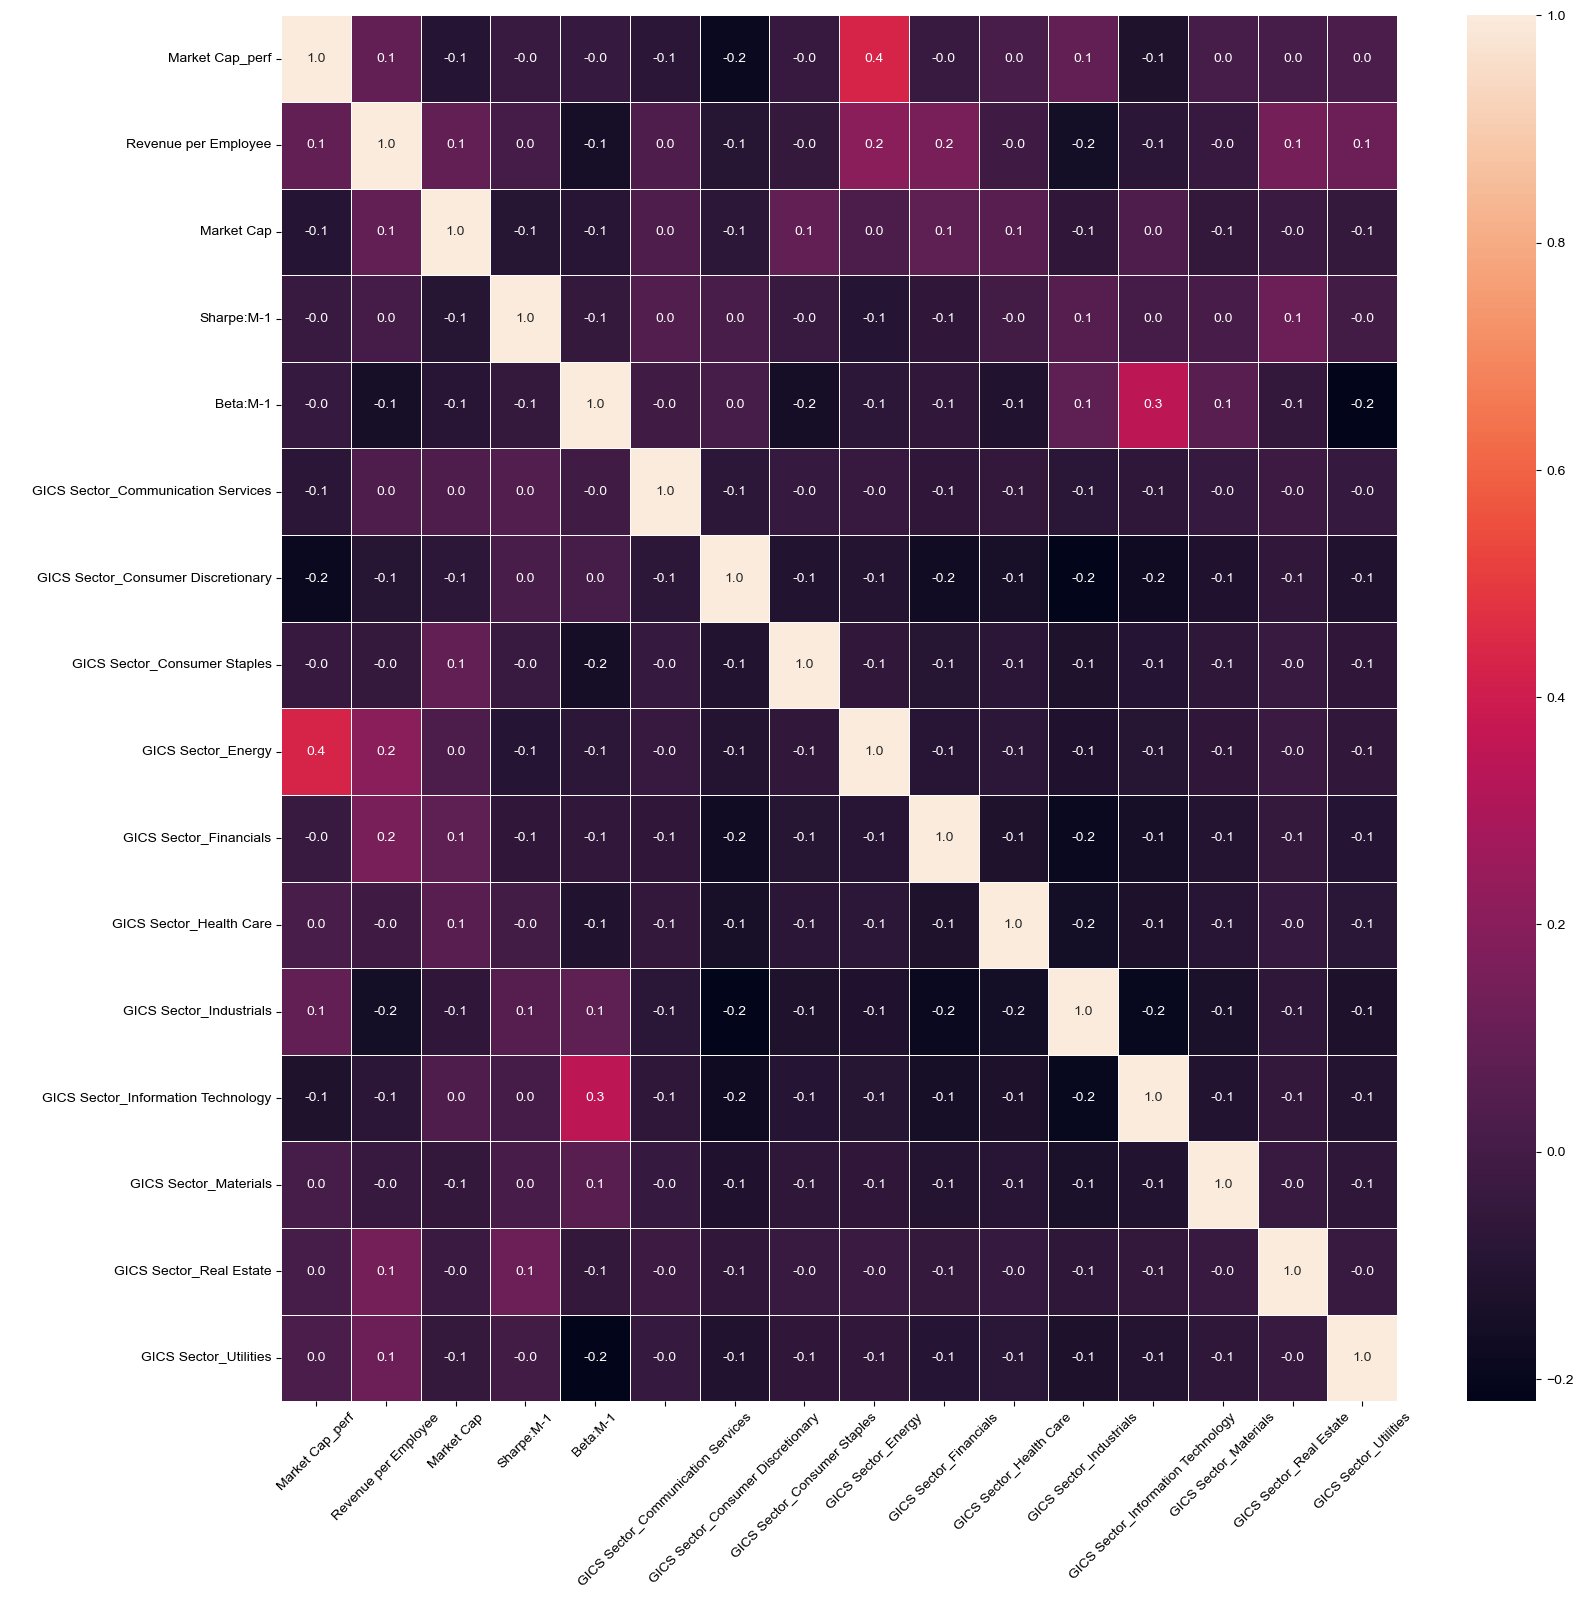


Data decription for cleaned SPR_Period_2.xlsx
GICS Sector
Industrials               216
Financials                198
Consumer Discretionary    196
Information Technology    162
Health Care               139
Real Estate                82
Materials                  81
Consumer Staples           65
Utilities                  52
Communication Services     47
Energy                     31
Name: count, dtype: int64
       Market Cap_perf  Revenue per Employee     Market Cap
count      1269.000000          1.269000e+03    1269.000000
mean          0.145752          9.019770e+05   16865.722069
std           0.310371          2.643064e+06   47038.230613
min          -0.839416          2.457104e+04     144.281000
25%          -0.031057          2.482764e+05    1402.683200
50%           0.138096          3.864179e+05    3528.513100
75%           0.286780          7.353425e+05   12265.221500
max           2.616234          5.176925e+07  575108.507600


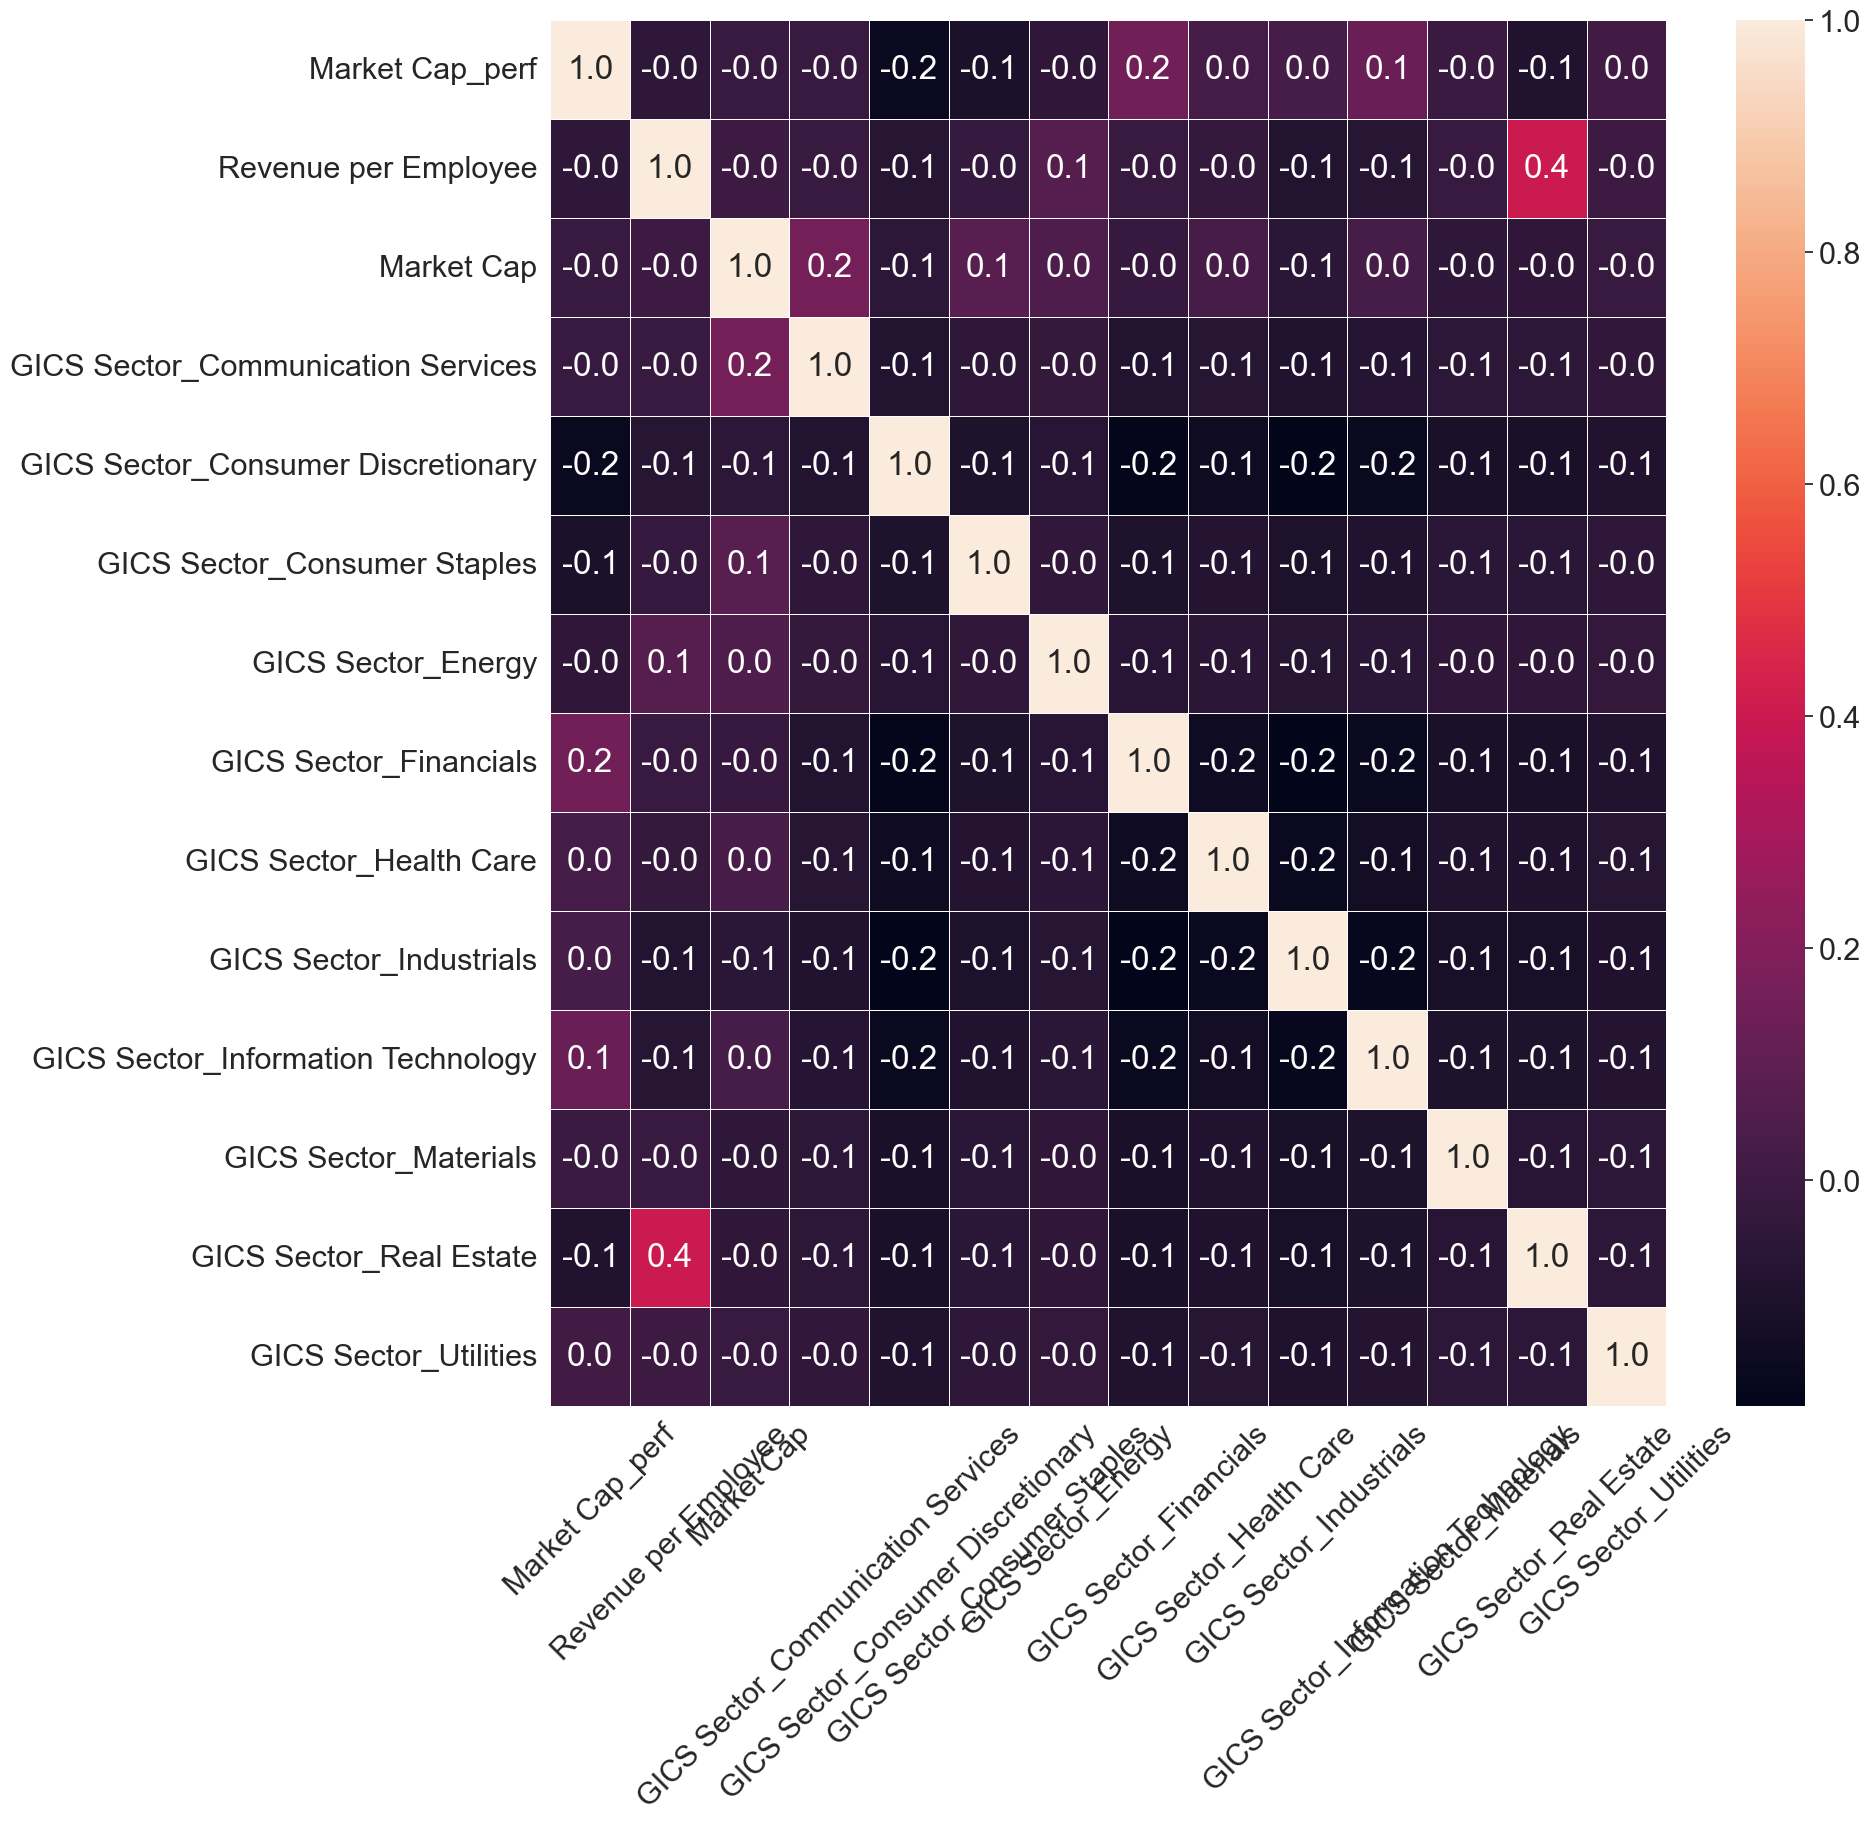


Data decription for cleaned SPR_Period_3.xlsx
GICS Sector
Industrials               221
Consumer Discretionary    207
Financials                196
Information Technology    164
Health Care               143
Real Estate                91
Materials                  77
Consumer Staples           65
Utilities                  48
Communication Services     46
Energy                     39
Name: count, dtype: int64
       Market Cap_perf  Revenue per Employee     Market Cap
count      1297.000000          1.297000e+03    1297.000000
mean          0.150803          9.279740e+05   18790.798789
std           0.314666          2.660655e+06   55517.775553
min          -0.882032          2.241154e+04     105.860000
25%          -0.042641          2.495037e+05    1526.499100
50%           0.102934          4.043673e+05    3917.466100
75%           0.284772          7.870889e+05   13333.739800
max           2.378570          4.657489e+07  847355.653400


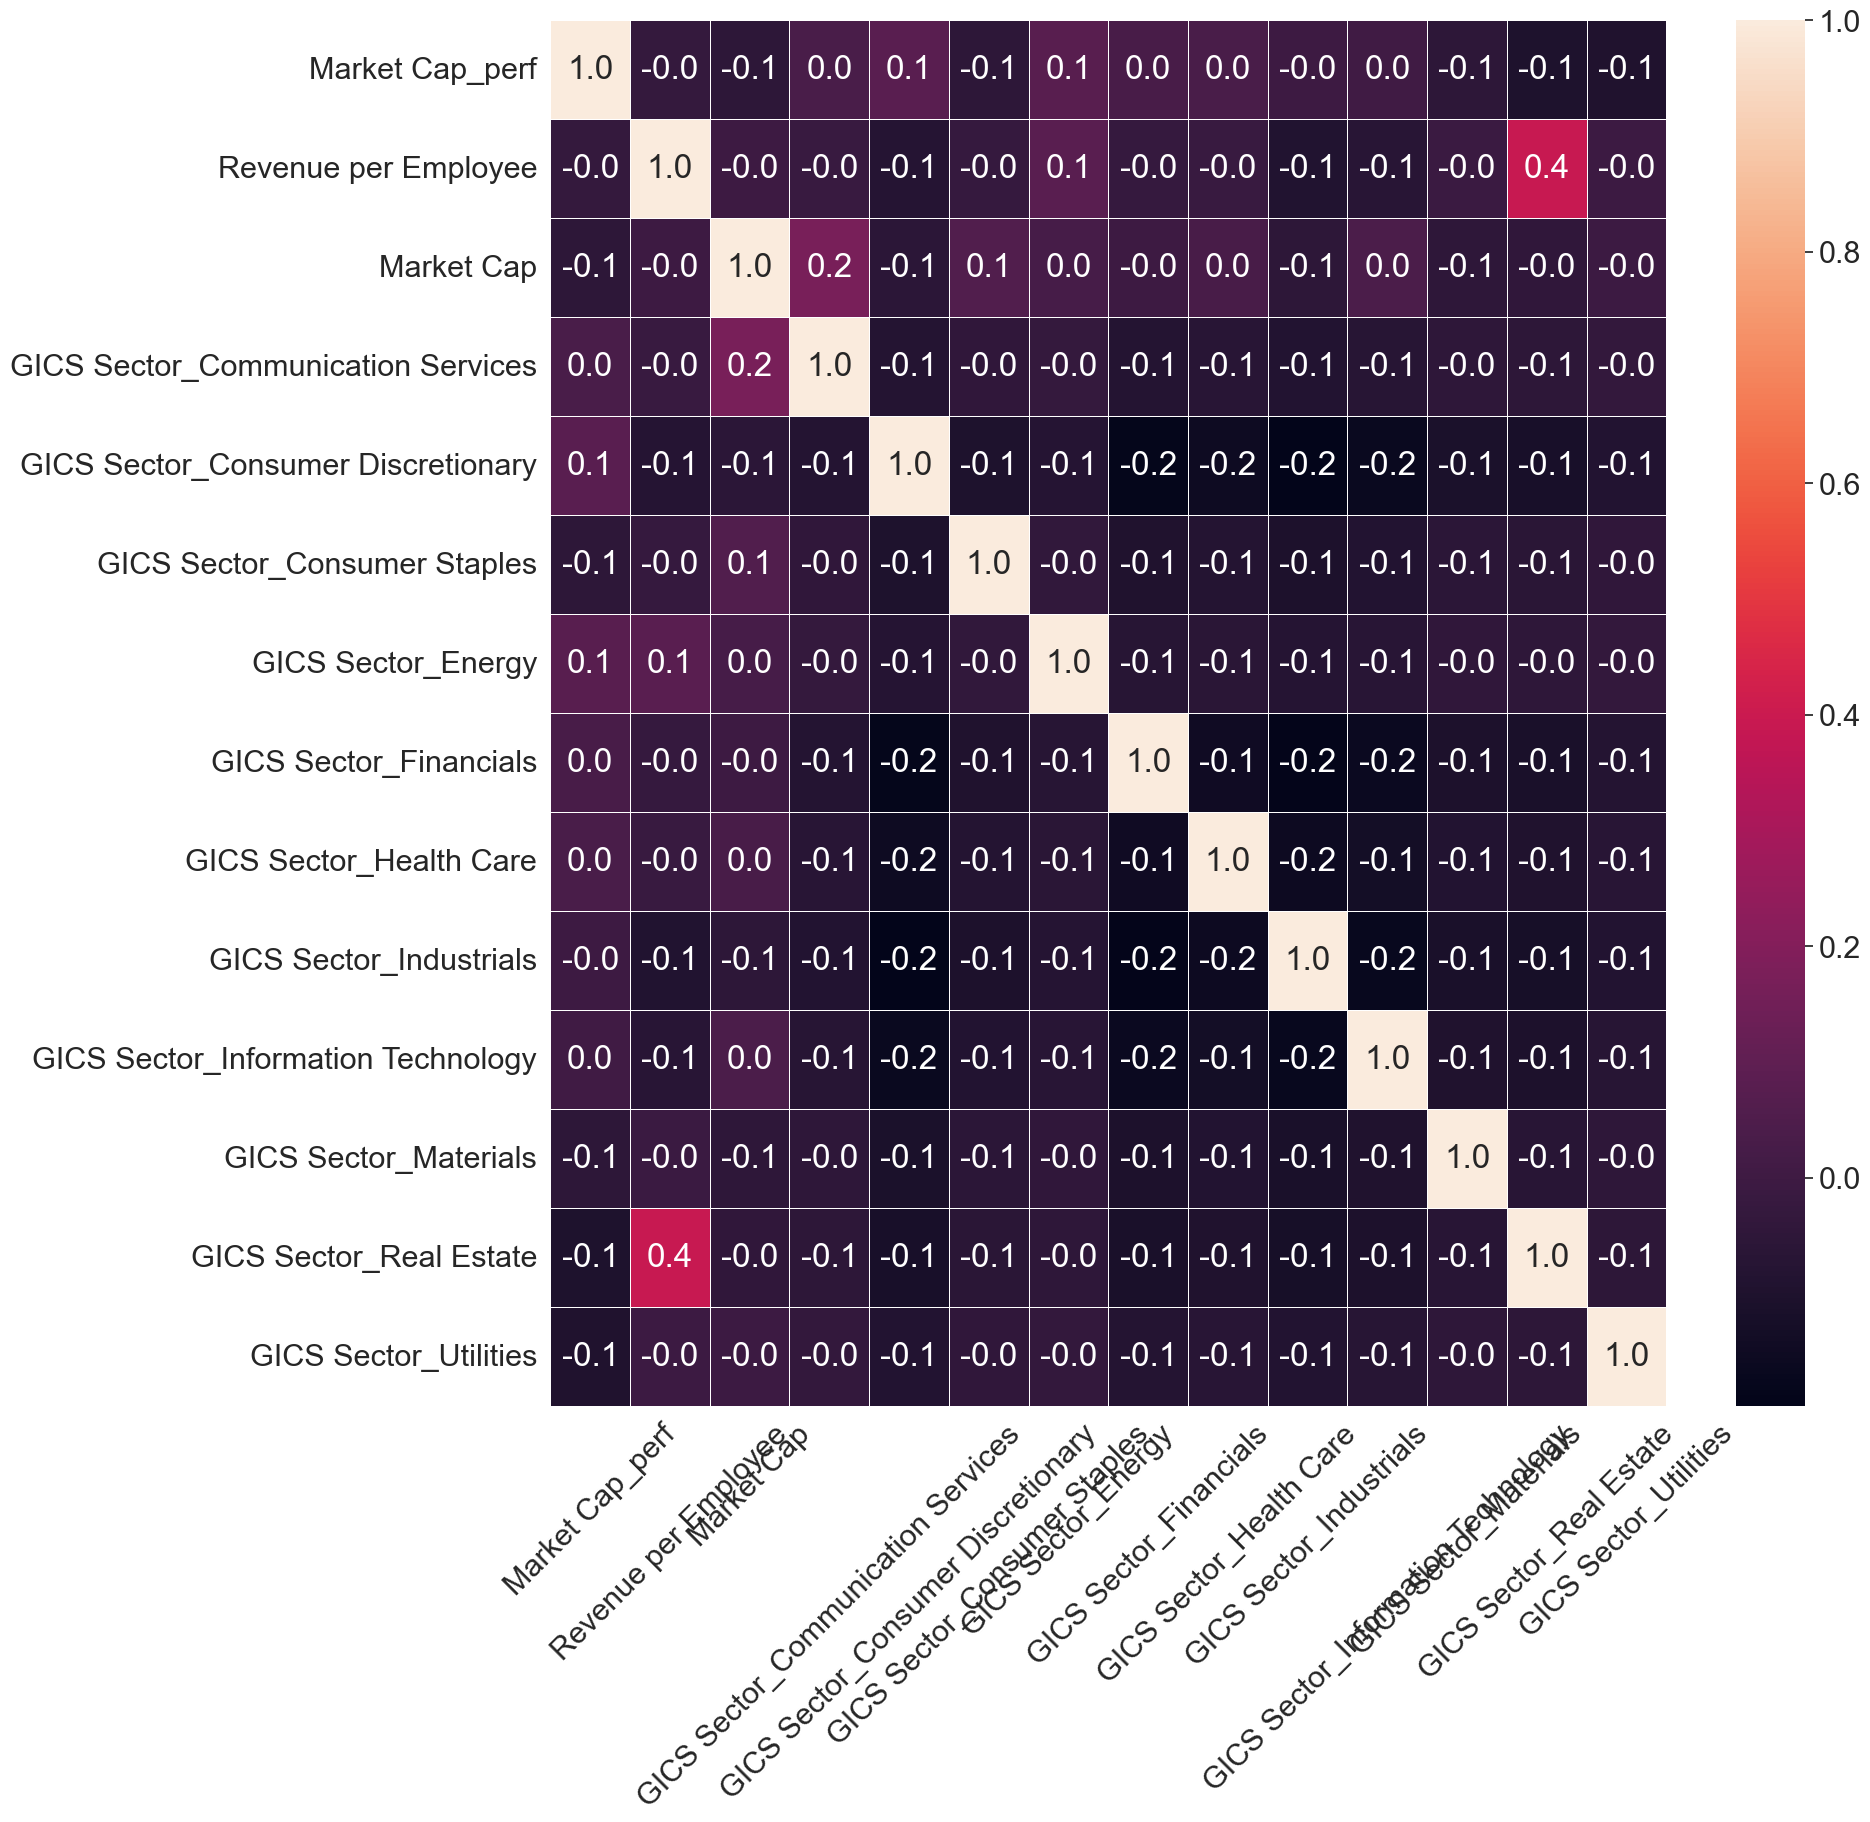


Data decription for cleaned SPR_Period_4.xlsx
GICS Sector
Financials                214
Industrials               204
Consumer Discretionary    187
Information Technology    163
Health Care               147
Materials                  77
Consumer Staples           73
Real Estate                73
Utilities                  48
Energy                     43
Communication Services     41
Name: count, dtype: int64
       Market Cap_perf  Revenue per Employee    Market Cap
count      1270.000000          1.270000e+03  1.270000e+03
mean         -0.148952          1.681369e+06  3.716714e+04
std           0.285485          2.446662e+07  1.588635e+05
min          -0.925602          0.000000e+00  2.625325e+02
25%          -0.325974          2.873606e+05  2.475682e+03
50%          -0.156679          4.597162e+05  6.106569e+03
75%           0.023768          9.459195e+05  2.262599e+04
max           1.598834          8.679870e+08  2.986128e+06


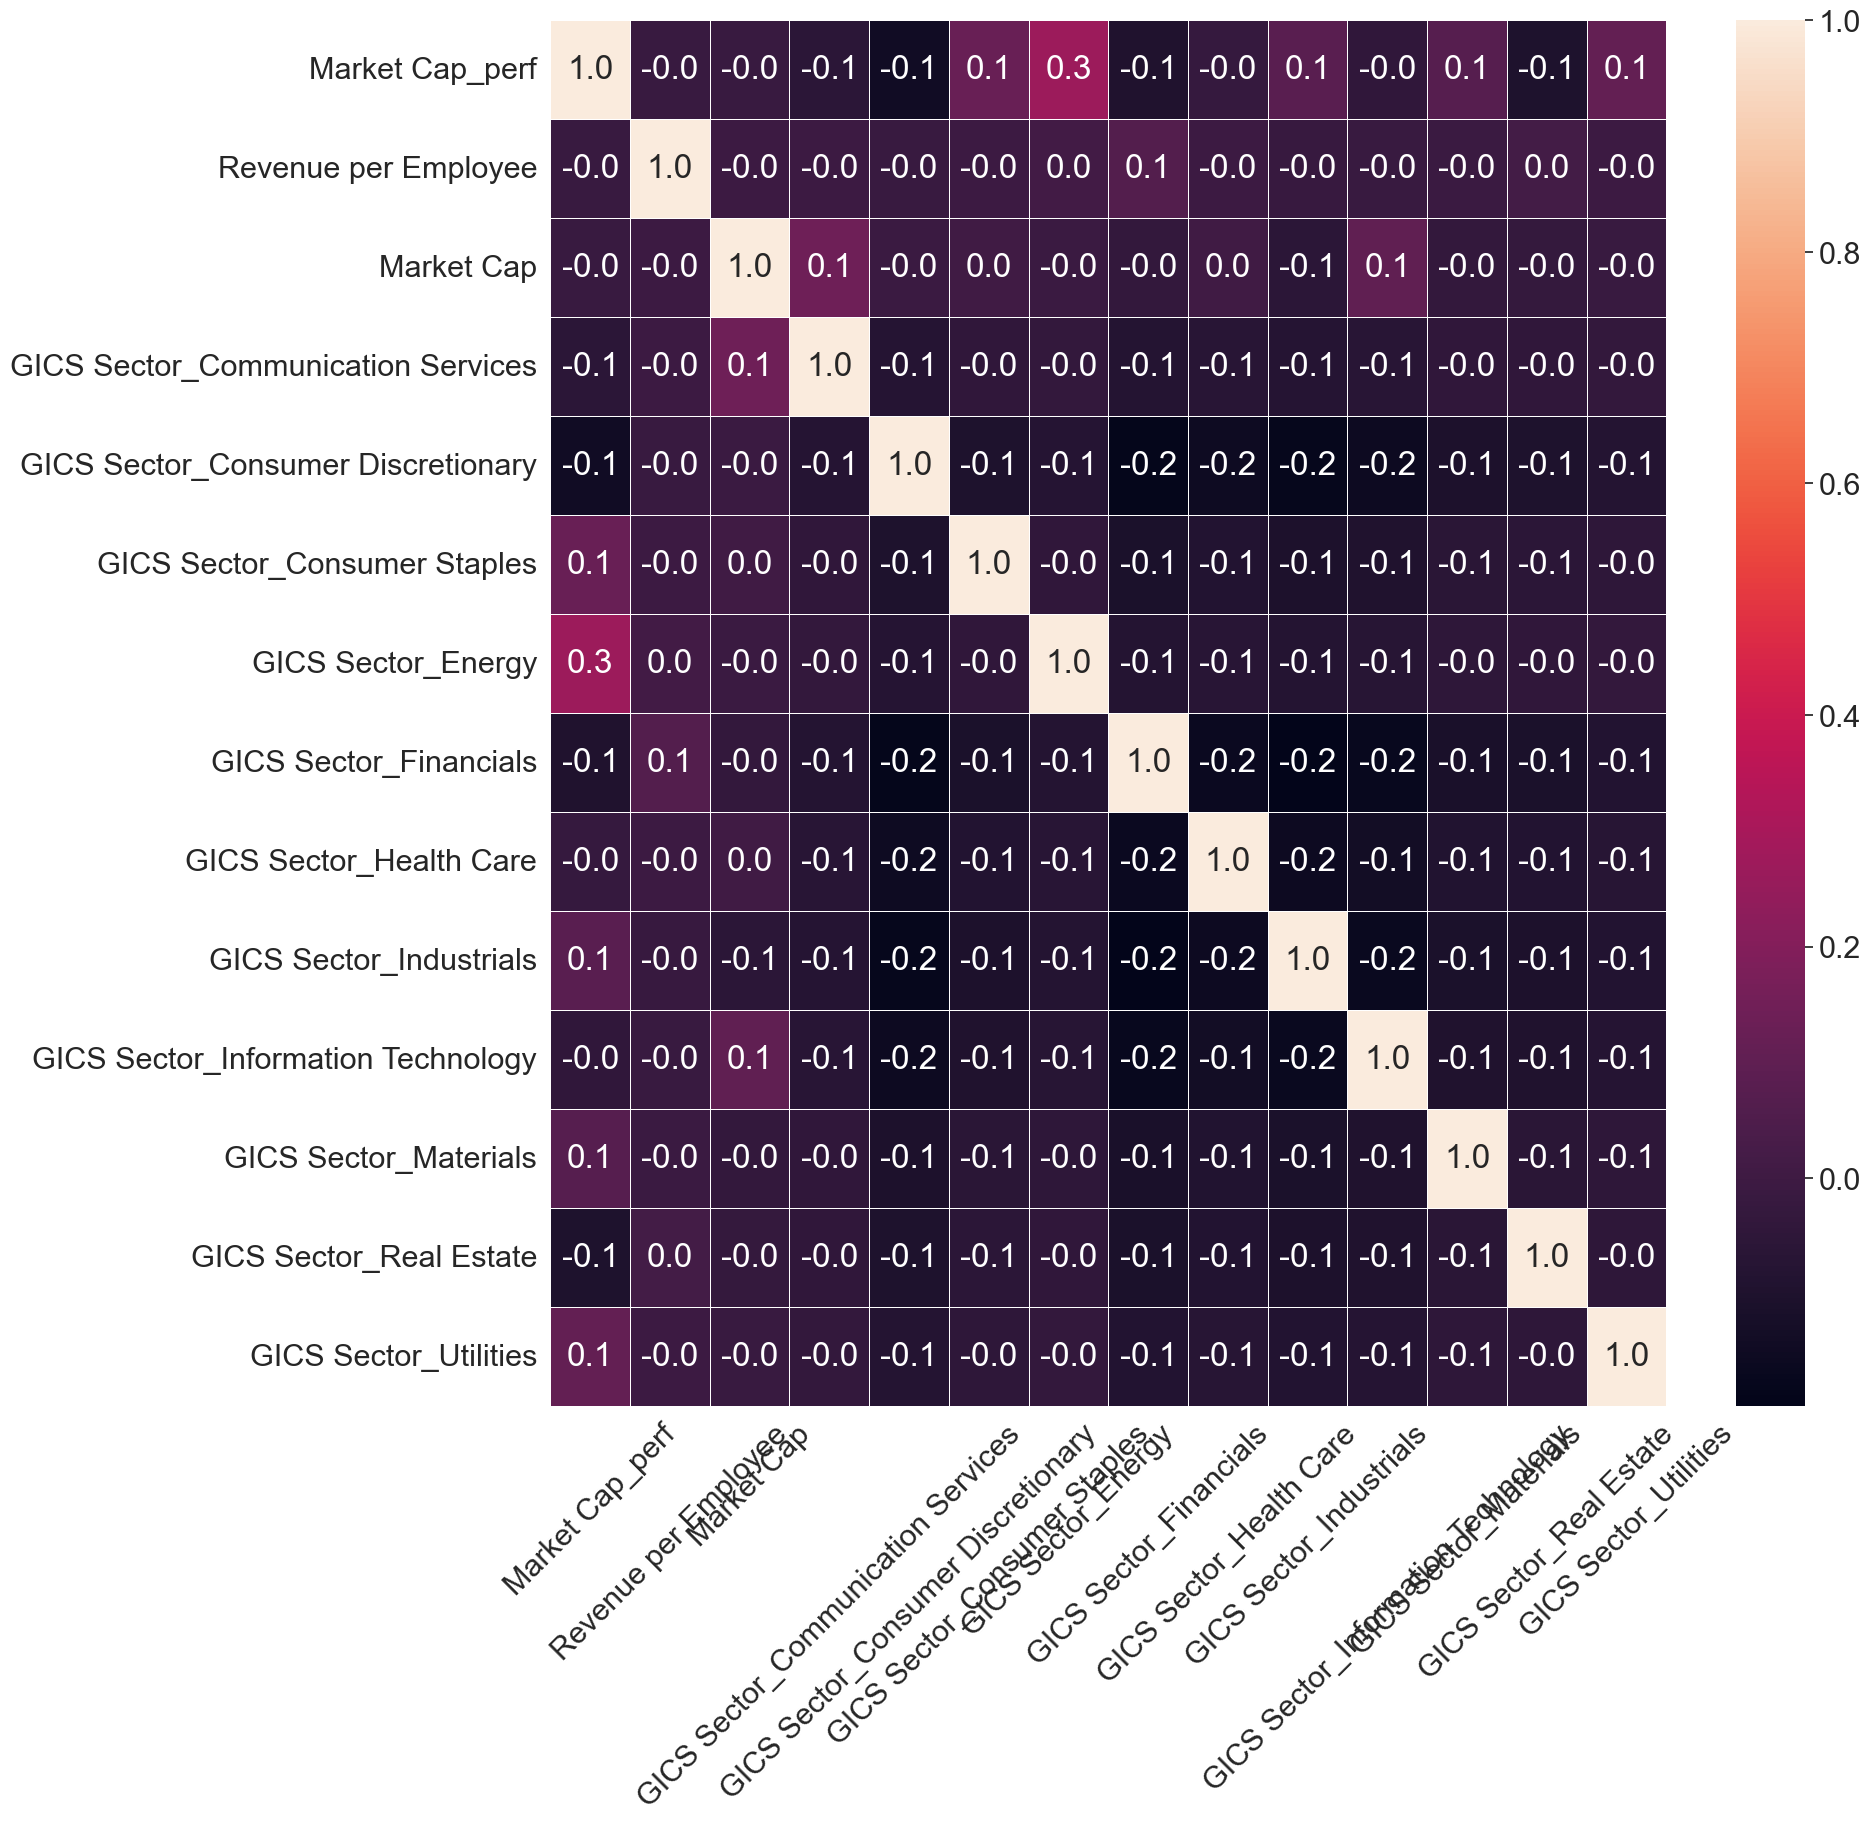

In [13]:
P1 = df("SPR_Period_1.xlsx")
P1.to_pickle("data/P1.pkl")
P2 = df("SPR_Period_2.xlsx")
P2.to_pickle("data/P2.pkl")
P3 = df("SPR_Period_3.xlsx")
P3.to_pickle("data/P3.pkl")
CrP = df("SPR_Period_4.xlsx")
CrP.to_pickle("data/CrP.pkl")

In [14]:
# saving the pre-processed dfs for easy access

P1 = pd.read_pickle("data/P1.pkl")
P2 = pd.read_pickle("data/P2.pkl")
P3 = pd.read_pickle("data/P3.pkl")
CrP = pd.read_pickle("data/CrP.pkl")


Data description for all periods (including current period)
GICS Sector
Industrials               786
Consumer Discretionary    710
Financials                702
Information Technology    587
Health Care               498
Materials                 286
Real Estate               260
Consumer Staples          247
Utilities                 195
Communication Services    156
Energy                    153
Name: count, dtype: int64
       Market Cap_perf  Revenue per Employee    Market Cap
count      4580.000000          4.580000e+03  4.580000e+03
mean          0.089550          1.051530e+06  2.226057e+04
std           0.414938          1.304172e+07  9.347337e+04
min          -0.925602          0.000000e+00  1.058600e+02
25%          -0.143823          2.424445e+05  1.559422e+03
50%           0.049928          3.851413e+05  4.083165e+03
75%           0.251214          7.485898e+05  1.406112e+04
max           5.033335          8.679870e+08  2.986128e+06


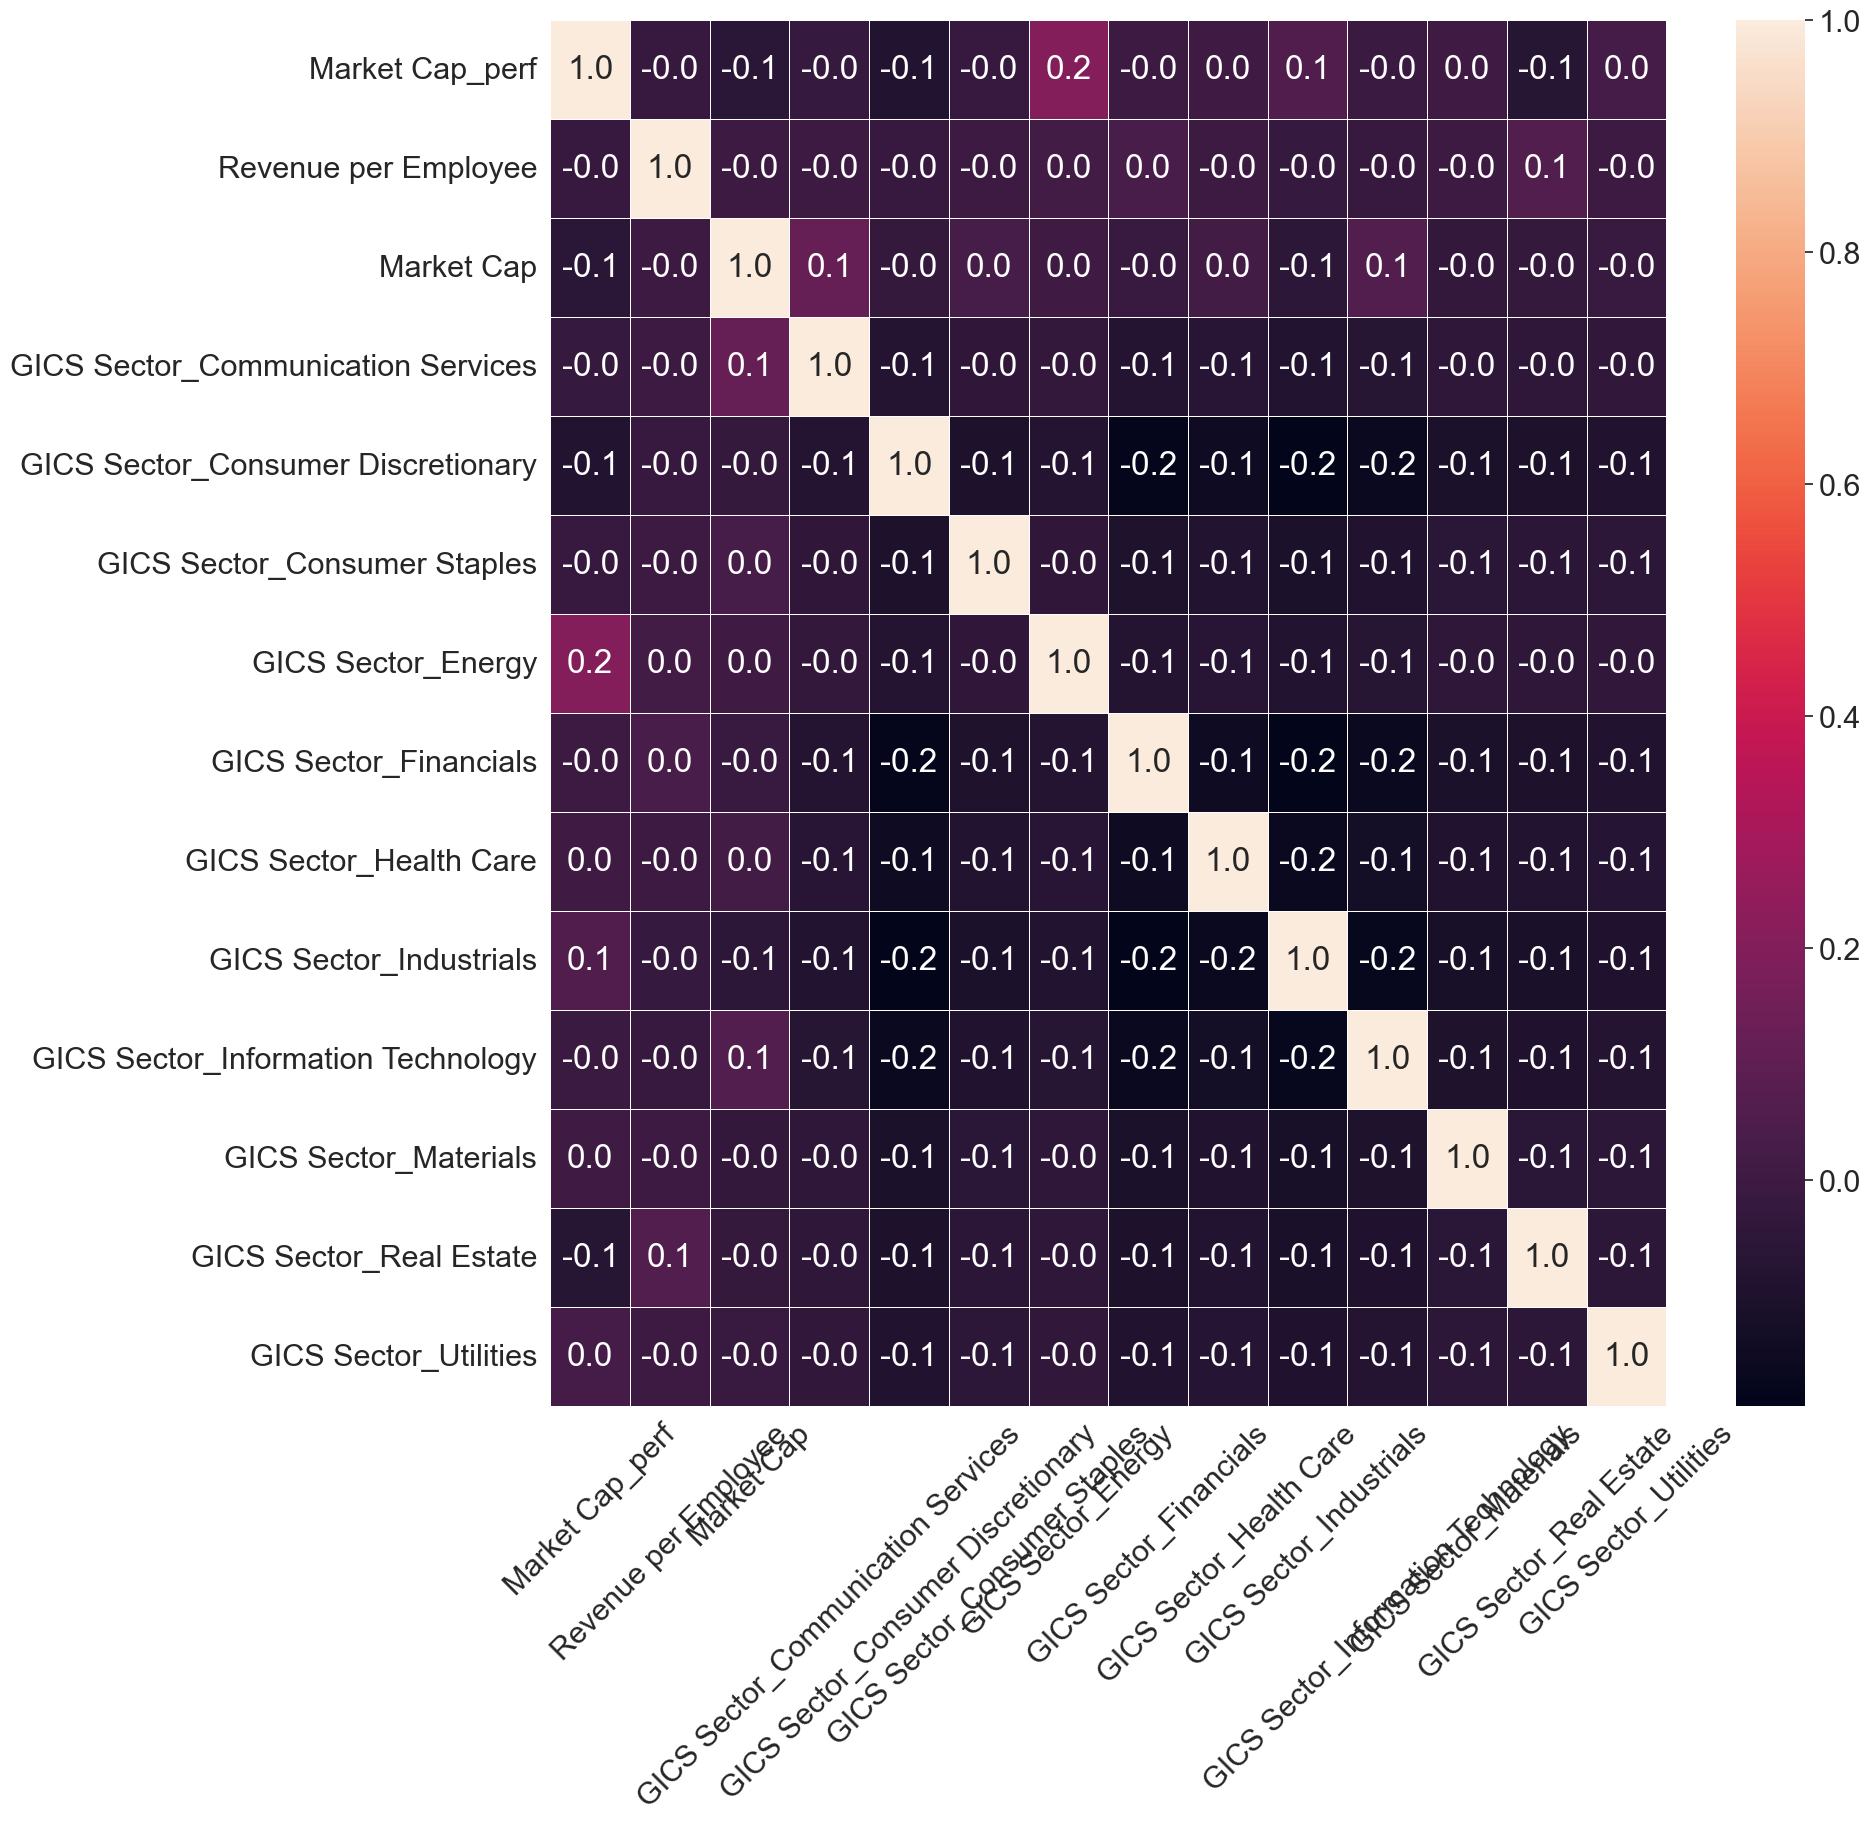

In [15]:
# creating a dataframe consisting of all data across periods
all_dfs = [P1, P2, P3, CrP]
all_df = pd.concat(all_dfs)

print("\nData description for all periods (including current period)")
perf = all_df.pop("Market Cap_perf")
all_df.insert(0, "Market Cap_perf", perf)

rpe = all_df.pop("Revenue per Employee")
all_df.insert(1, "Revenue per Employee", rpe)

print(all_df["GICS Sector"].value_counts(ascending=False))
print(all_df.iloc[:, :12].describe())

scatterplots(all_df)

heatmap(all_df)


Data decription for only concluded periods
GICS Sector
Industrials               582
Consumer Discretionary    523
Financials                488
Information Technology    424
Health Care               351
Materials                 209
Real Estate               187
Consumer Staples          174
Utilities                 147
Communication Services    115
Energy                    110
Name: count, dtype: int64
       Market Cap_perf  Revenue per Employee     Market Cap
count      3310.000000          3.310000e+03    3310.000000
mean          0.181060          8.098693e+05   16541.132647
std           0.420463          2.363555e+06   47896.088008
min          -0.916199          2.241154e+04     105.860000
25%          -0.045230          2.300026e+05    1401.645550
50%           0.130913          3.599069e+05    3471.415900
75%           0.315884          6.920711e+05   11867.860650
max           5.033335          5.176925e+07  847355.653400


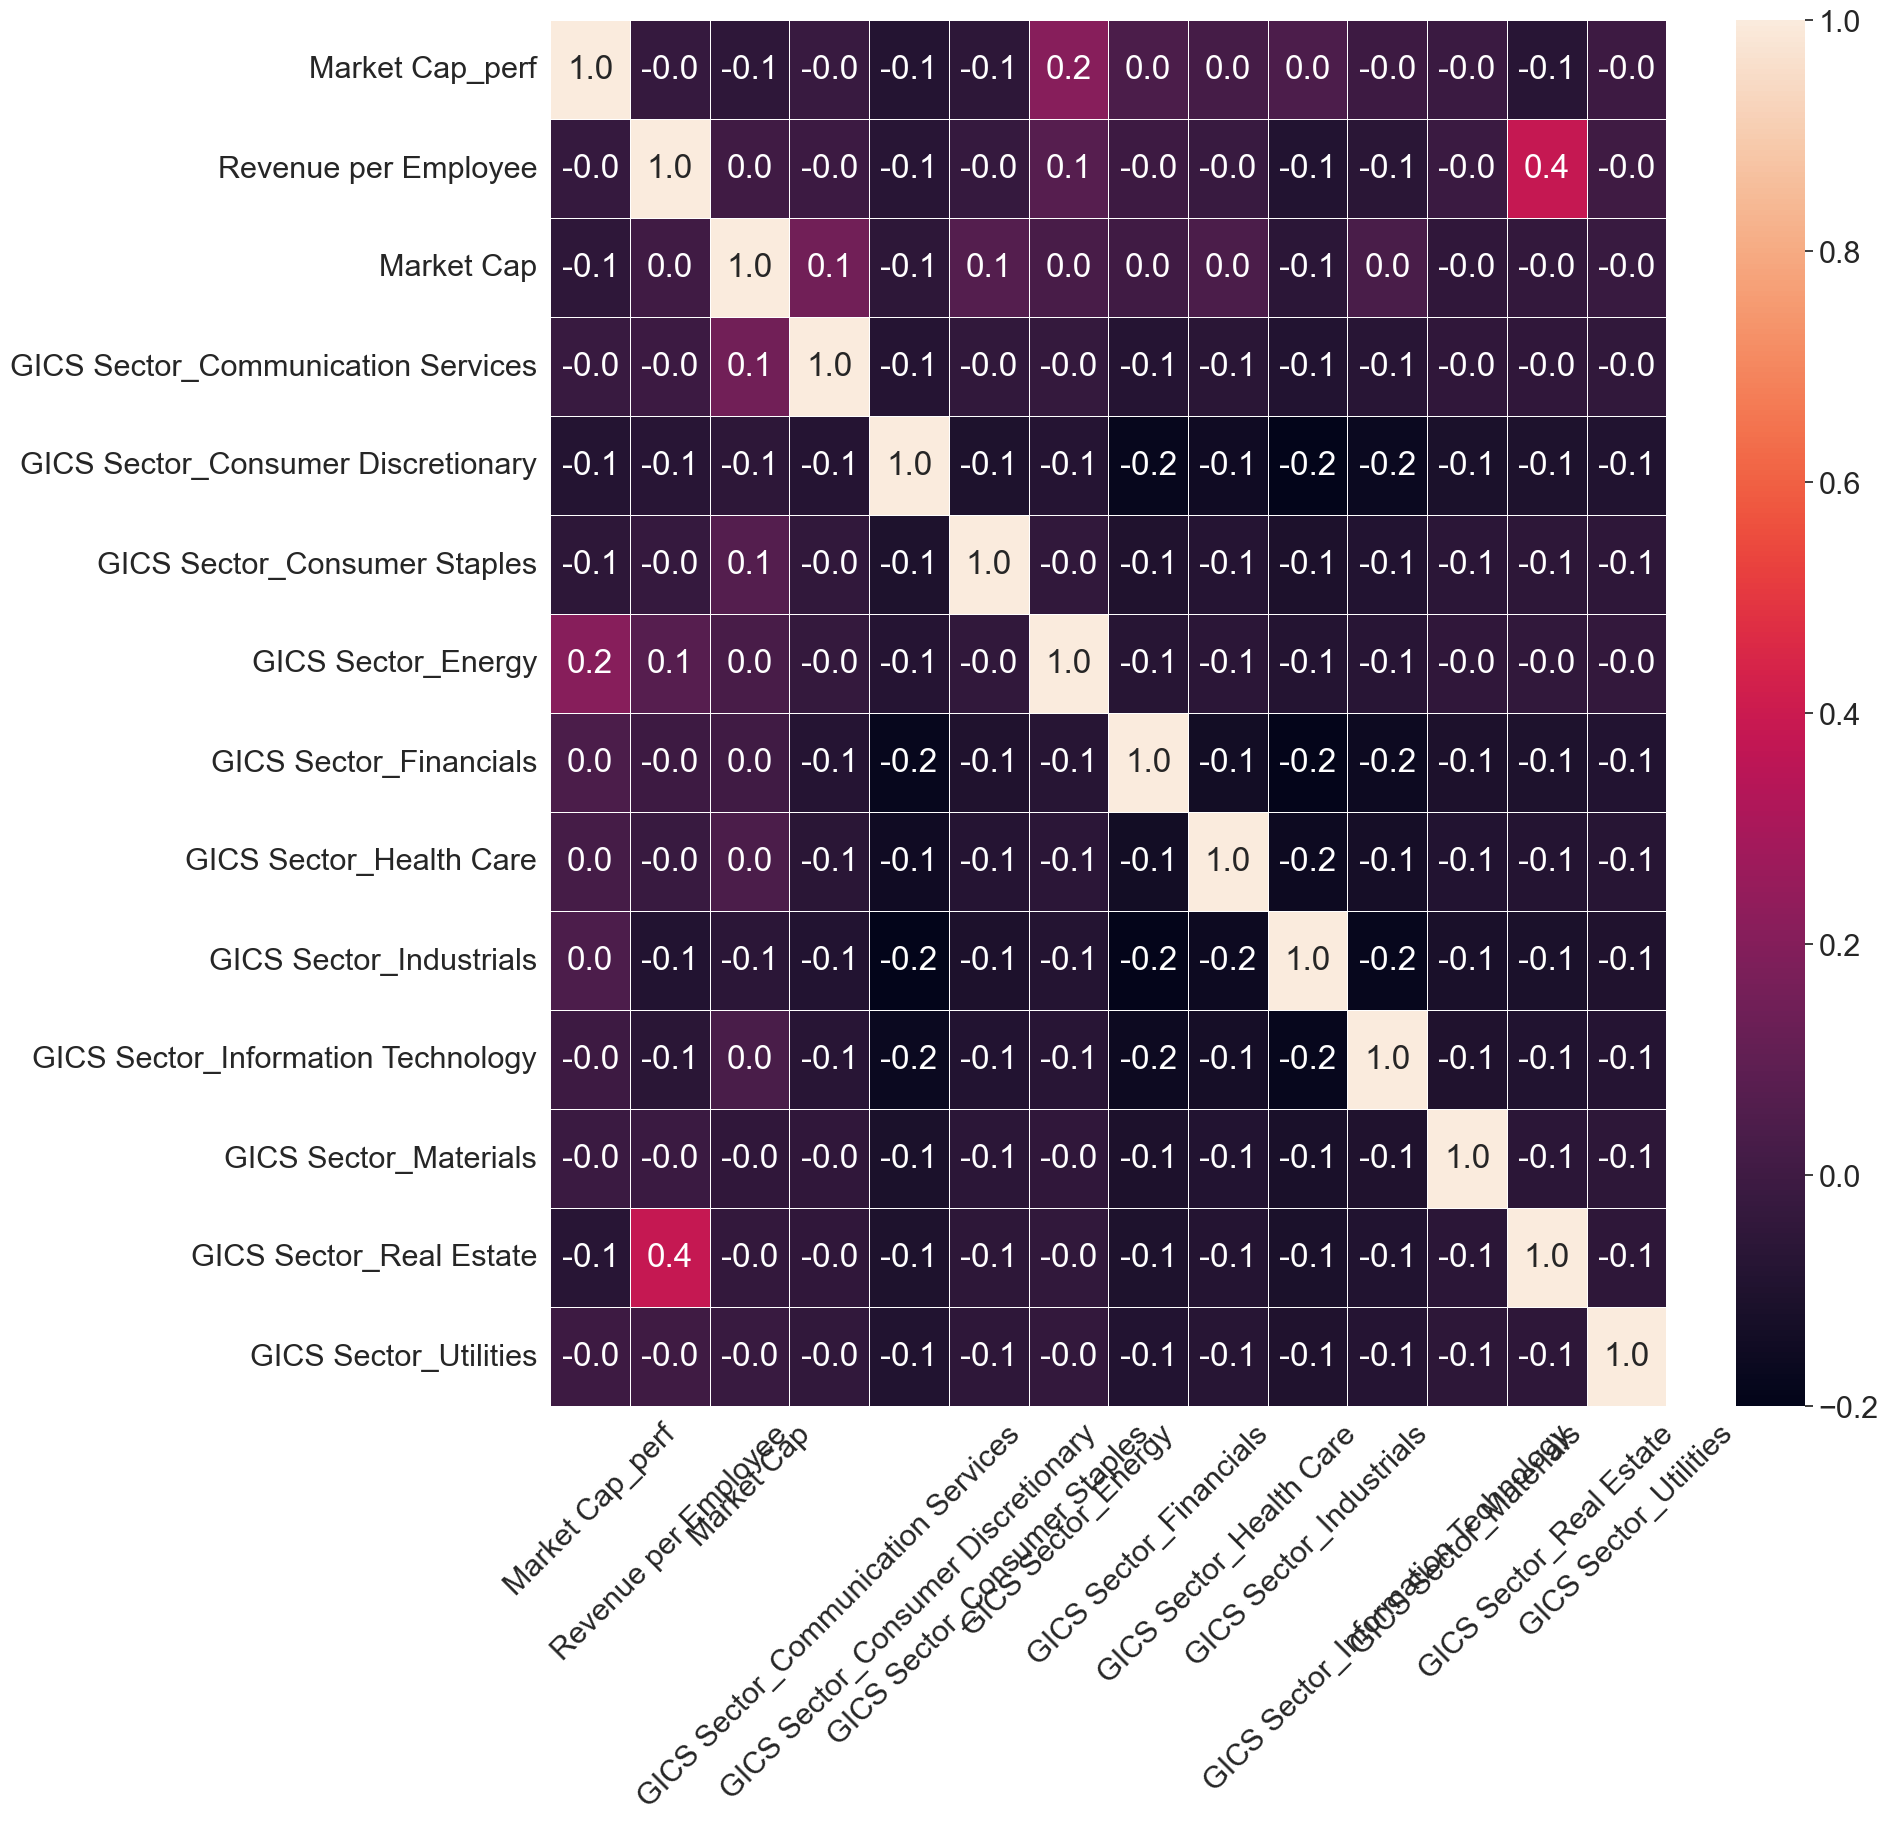

In [16]:
# creating a df consisting only of concluded periods

concluded_dfs = [P1, P2, P3]
concluded_df = pd.concat(concluded_dfs)

print("\nData decription for only concluded periods")
perf = concluded_df.pop("Market Cap_perf")
concluded_df.insert(0, "Market Cap_perf", perf)

rpe = concluded_df.pop("Revenue per Employee")
concluded_df.insert(1, "Revenue per Employee", rpe)

print(concluded_df["GICS Sector"].value_counts(ascending=False))
print(concluded_df.iloc[:, :12].describe())

scatterplots(concluded_df)

heatmap(concluded_df)

GICS Sector
Energy                    5
Industrials               5
Consumer Discretionary    5
Health Care               4
Financials                4
Information Technology    3
Materials                 2
Communication Services    1
Consumer Staples          1
Name: count, dtype: int64
       Market Cap_perf  Revenue per Employee    Market Cap
count        30.000000          3.000000e+01     30.000000
mean          2.280571          5.911873e+05   3358.930623
std           0.977822          4.769266e+05   6469.283667
min           1.308081          1.006522e+05    245.865200
25%           1.500476          2.704801e+05    473.586450
50%           1.992901          4.660659e+05   1135.774550
75%           2.539989          8.024246e+05   2422.908625
max           5.033335          2.353037e+06  33785.250000


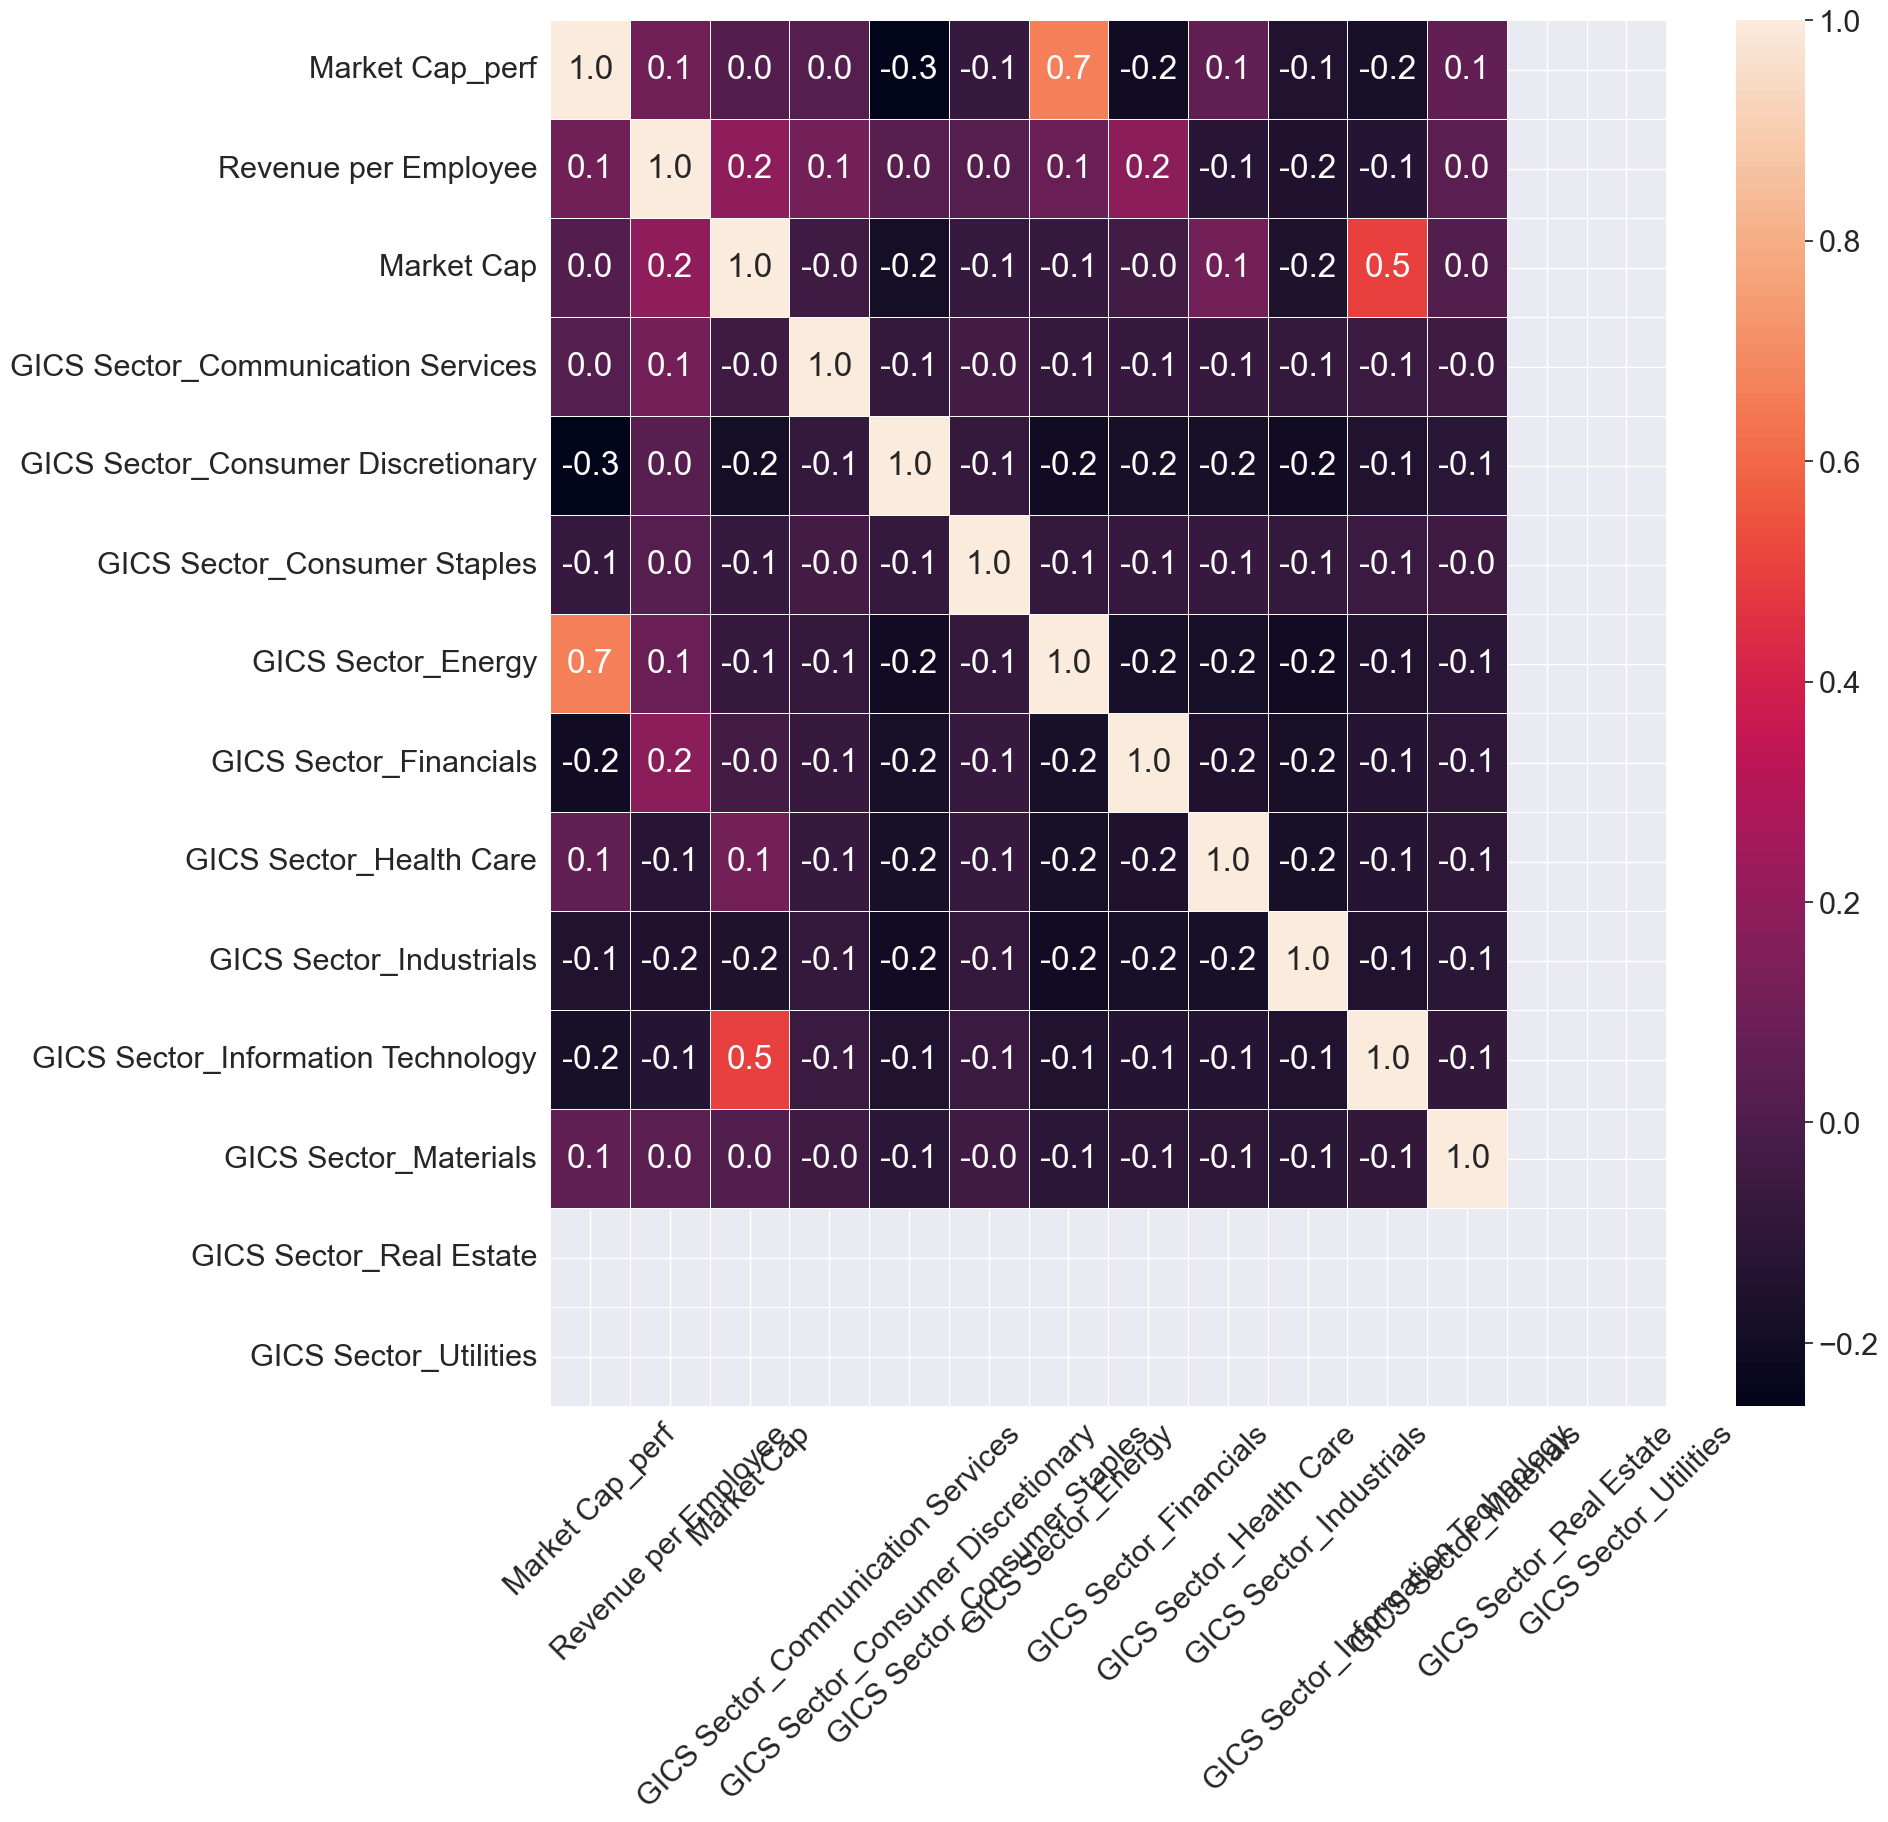

In [17]:
# insight into the characteristics of the best performing observations

top10 = pd.DataFrame()

for df in concluded_dfs:
    top10 = pd.concat(
        [top10, df.sort_values("Market Cap_perf", ascending=False).head(10)]
    )

perf = top10.pop("Market Cap_perf")
top10.insert(0, "Market Cap_perf", perf)

rpe = top10.pop("Revenue per Employee")
top10.insert(1, "Revenue per Employee", rpe)

print(top10["GICS Sector"].value_counts(ascending=False))
print(top10.iloc[:, :12].describe())

top10.sort_values("Market Cap_perf", ascending=False)

heatmap(top10)


## 3. Machine learning

### Basic Decision Tree

In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score

# function to quickly retrieve minimal evaluation data for the classifier


def evaluate(clf, X_train, X_test, y_train, y_test):
    print("Train Accuracy :", accuracy_score(y_train, clf.predict(X_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, clf.predict(X_train)))
    print("Test Accuracy :", accuracy_score(y_test, clf.predict(X_test)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, clf.predict(X_test)))


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree


def decision_tree(df, title):
    df["Compared Performance"] = np.where(
        (df["Market Cap_perf"] > df["Market Cap_perf"].mean()),
        "Outperformed",
        "Not Outperformed",
    )
    y = df["Compared Performance"]
    X = df.drop(
        columns=["Compared Performance",
                 "Market Cap_perf", "Name", "GICS Sector"]
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=222
    )

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.countplot(x="Compared Performance", data=df)
    plt.title("Target distribution")
    plt.show()

    print(f"X_train : {X_train.shape}")
    print(f"y_train : {y_train.shape}")
    print(f"X_test : {X_test.shape}")
    print(f"y_test : {y_test.shape}")

    print(title)
    dt = DecisionTreeClassifier(max_depth=2)

    dt.fit(X_train, y_train)

    fig, ax = plt.subplots(figsize=(30, 30))
    plot_tree(
        dt,
        feature_names=X.columns,
        class_names=["Outperformed", "Not Outperformed"],
        filled=True,
        proportion=False,
        fontsize=35,
    )

    evaluate(dt, X_train, X_test, y_train, y_test)


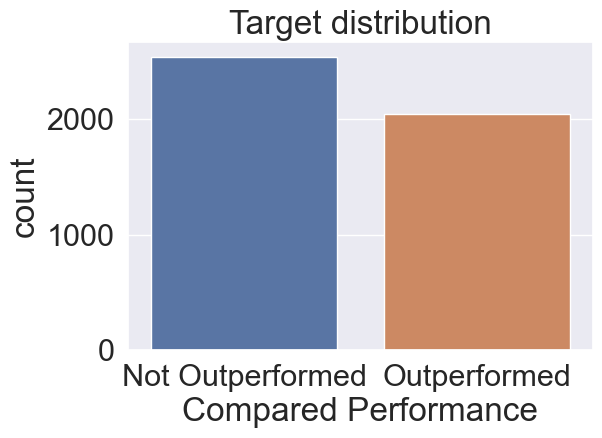

X_train : (4122, 20)
y_train : (4122,)
X_test : (458, 20)
y_test : (458,)
Using the data of all periods (including the current, ongoing one)
Train Accuracy : 0.5528869480834546
Train Confusion Matrix:
[[ 775 1495]
 [ 348 1504]]
Test Accuracy : 0.5
Test Confusion Matrix:
[[ 80 185]
 [ 44 149]]


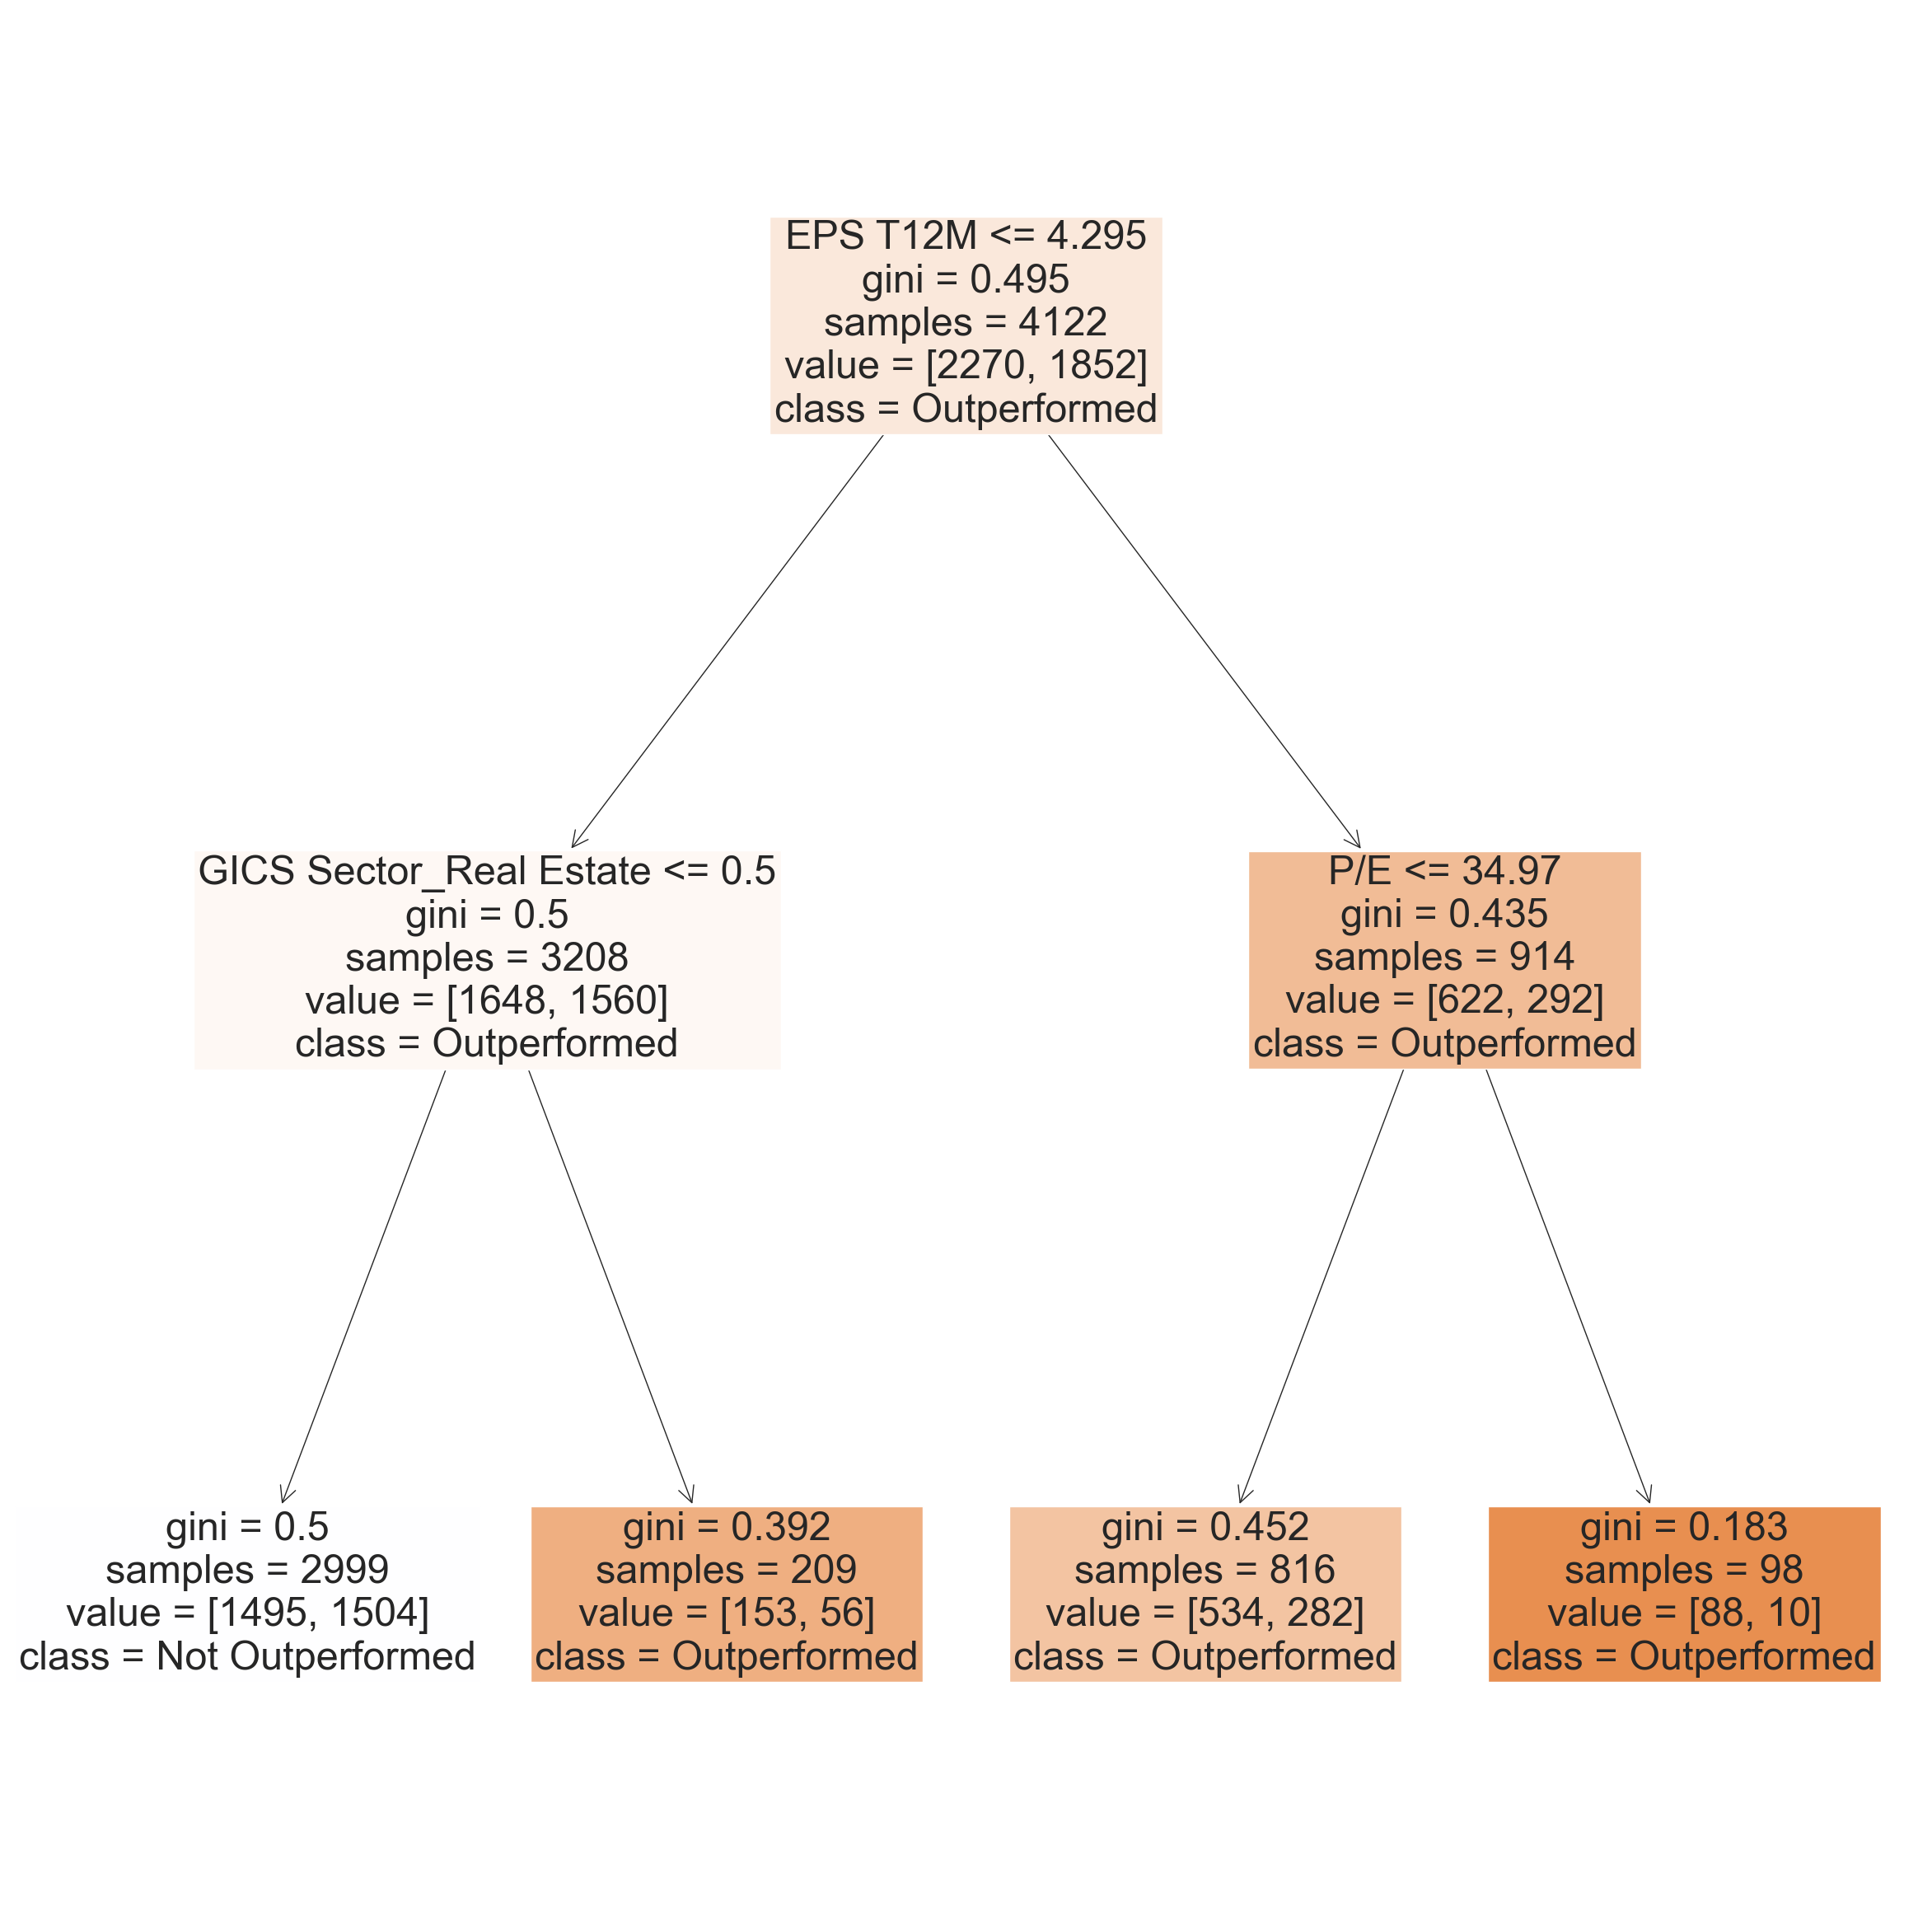

In [20]:
decision_tree(
    all_df, "Using the data of all periods (including the current, ongoing one)"
)


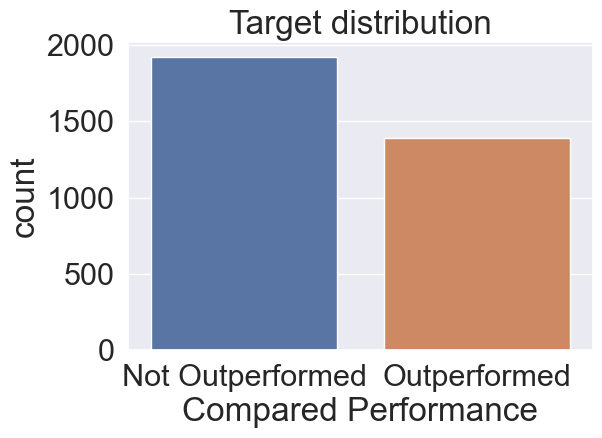

X_train : (2979, 20)
y_train : (2979,)
X_test : (331, 20)
y_test : (331,)
Using the data of only concluded periods
Train Accuracy : 0.5918093319906008
Train Confusion Matrix:
[[1383  326]
 [ 890  380]]
Test Accuracy : 0.5981873111782477
Test Confusion Matrix:
[[164  48]
 [ 85  34]]


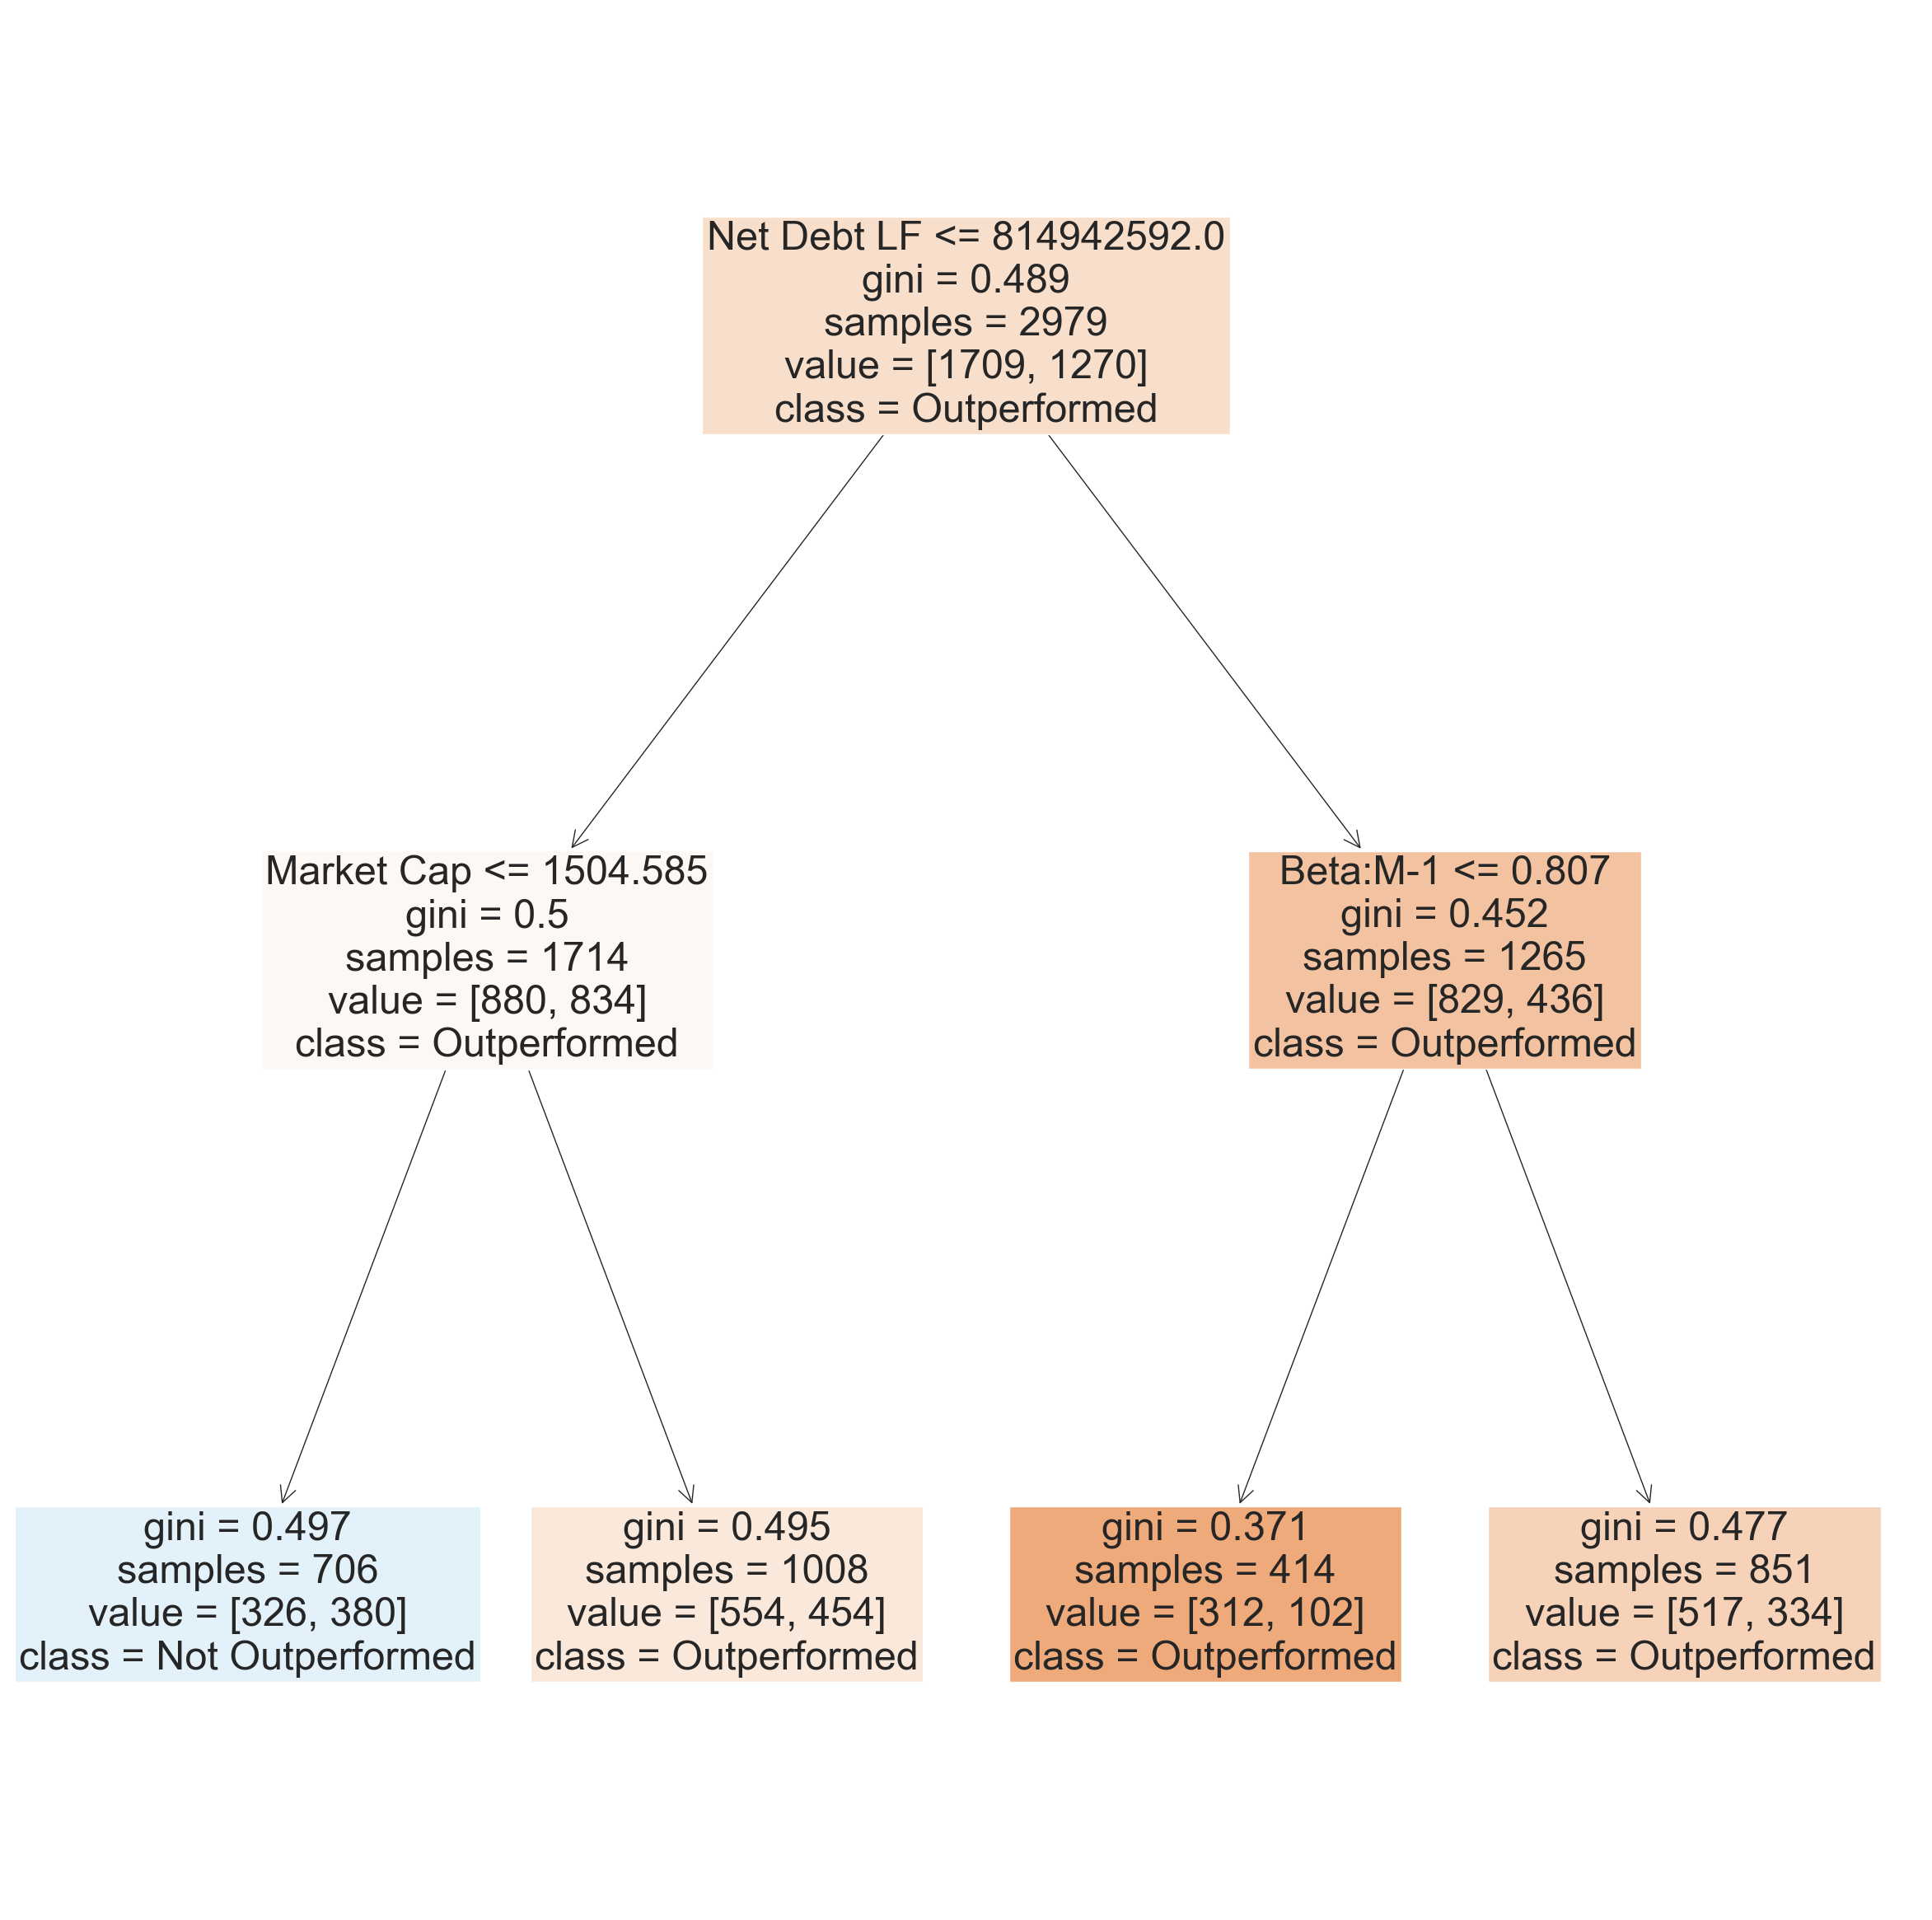

In [21]:
decision_tree(concluded_df, "Using the data of only concluded periods")


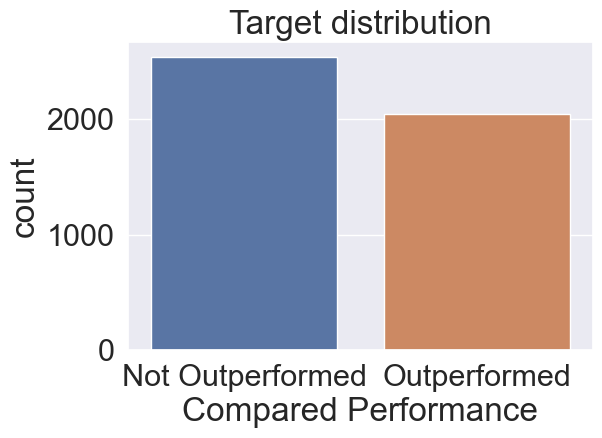

X_train : (3310, 20)
y_train : (3310,)
X_test : (1270, 20)
y_test : (1270,)
Using the data of concluded periods as training data and the current, ongoing period data, as test data
Train Accuracy : 0.592749244712991
Train Confusion Matrix:
[[1565  356]
 [ 992  397]]
Test Accuracy : 0.5062992125984253
Test Confusion Matrix:
[[571  85]
 [542  72]]


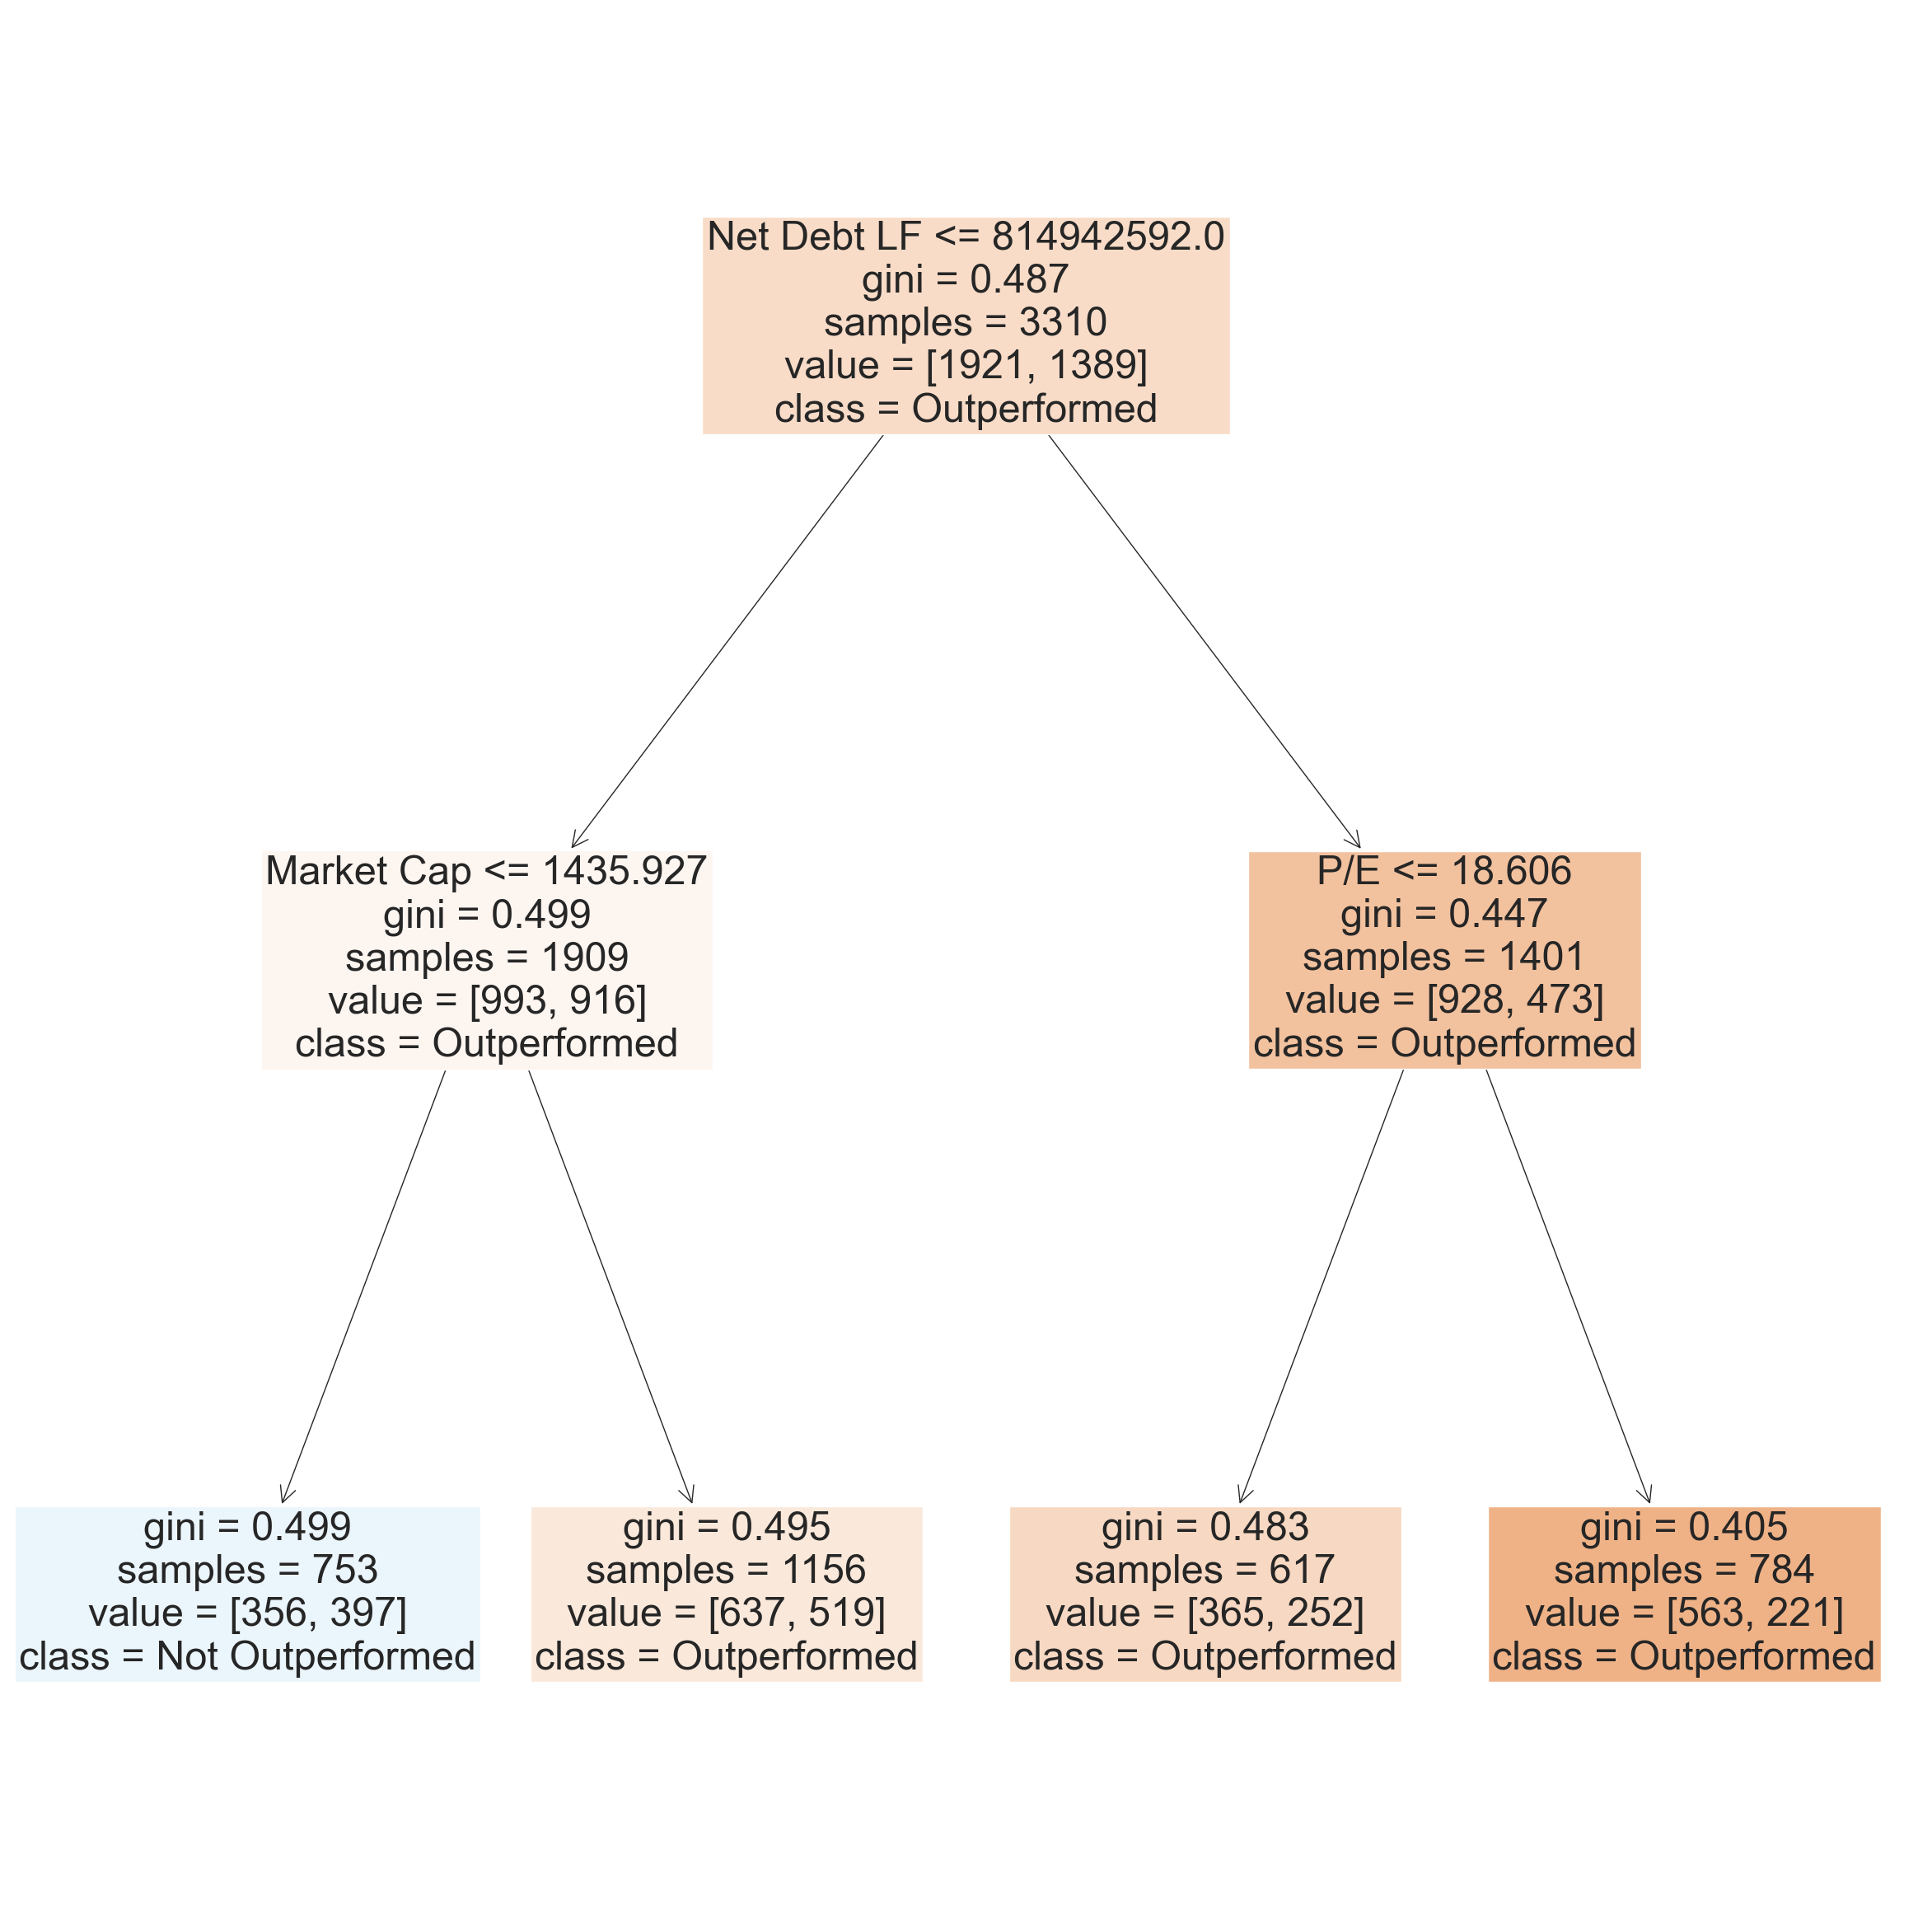

In [22]:
concluded_df["Compared Performance"] = np.where(
    (concluded_df["Market Cap_perf"] > concluded_df["Market Cap_perf"].mean()),
    "Outperformed",
    "Not Outperformed",
)
y_train = concluded_df["Compared Performance"]
X_train = concluded_df.drop(
    columns=["Compared Performance", "Market Cap_perf", "Name", "GICS Sector"]
)

CrP["Compared Performance"] = np.where(
    (CrP["Market Cap_perf"] > CrP["Market Cap_perf"].mean()),
    "Outperformed",
    "Not Outperformed",
)
y_test = CrP["Compared Performance"]
X_test = CrP.drop(
    columns=["Compared Performance", "Market Cap_perf", "Name", "GICS Sector"]
)

fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x="Compared Performance", data=all_df)
plt.title("Target distribution")
plt.show()

print(f"X_train : {X_train.shape}")
print(f"y_train : {y_train.shape}")
print(f"X_test : {X_test.shape}")
print(f"y_test : {y_test.shape}")

print(
    "Using the data of concluded periods as training data and the current, ongoing period data, as test data"
)
dt = DecisionTreeClassifier(max_depth=2)

dt.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(
    dt,
    feature_names=X_train.columns,
    class_names=["Outperformed", "Not Outperformed"],
    filled=True,
    proportion=False,
    fontsize=35,
)

evaluate(dt, X_train, X_test, y_train, y_test)


### 3.2 Random Forest with Hyperparametertuning

In [23]:
n_estimators = np.arange(50, 250, 50)
max_features = ["auto", "sqrt"]
max_depth = np.arange(2, 20, 1)
min_samples_leaf = [1, 5, 25, 50]
min_samples_split = [2, 5, 25, 50]
max_leaf_nodes = [50, 100, 250, 500]
bootstrap = [True, False]

params_arr = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_leaf": min_samples_leaf,
    "min_samples_split": min_samples_split,
    "max_leaf_nodes": max_leaf_nodes,
    "bootstrap": bootstrap,
}


In [24]:
from treeinterpreter import treeinterpreter as ti
import os
from sklearn.tree import export_graphviz
import six
import pydot
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()


def visualize_best(gridname, grid, X_test, X_train, y_test, y_train):
    params = {
        "n_estimators": [grid.best_params_["n_estimators"]],
        "max_features": [grid.best_params_["max_features"]],
        "max_depth": [grid.best_params_["max_depth"]],
        "min_samples_leaf": [grid.best_params_["min_samples_leaf"]],
        "min_samples_split": [grid.best_params_["min_samples_split"]],
        "max_leaf_nodes": [grid.best_params_["max_leaf_nodes"]],
        "bootstrap": [grid.best_params_["bootstrap"]],
    }

    clf = RandomForestClassifier(
        n_estimators=params["n_estimators"][0],
        max_features=params["max_features"][0],
        max_depth=params["max_depth"][0],
        min_samples_leaf=params["min_samples_leaf"][0],
        min_samples_split=params["min_samples_split"][0],
        max_leaf_nodes=params["max_leaf_nodes"][0],
        bootstrap=params["bootstrap"][0],
    )

    clf.fit(X_train.values, y_train.values)

    prediction, bias, contributions = ti.predict(clf, X_test.values)

    N = len(X_test.columns)

    outperformed = []
    not_outperformed = []

    for j in range(2):
        list_ = [outperformed, not_outperformed]
        for i in range(N - 1):
            val = contributions[0, i, j]
            list_[j].append(val)

    outperformed.append(prediction[0, 0] / N)
    not_outperformed.append(prediction[0, 1] / N)

    fig, ax = plt.subplots()
    ind = np.arange(N)

    width = 0.5

    p1 = ax.bar(ind, outperformed, width, color="green", bottom=0)
    p2 = ax.bar(ind + width, not_outperformed, width, color="red", bottom=0)

    ax.set_title("Feature importance for performance result")
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(X_train.columns, rotation=90)
    ax.legend((p1[0], p2[0]), ("Outperformed",
              "Not Outperformed"), loc="upper left")
    ax.autoscale_view()

    fig.set_figwidth(15)
    plt.show()

    dotfile = six.StringIO()

    i = 0
    for tree_in_forest in clf.estimators_:
        export_graphviz(
            tree_in_forest,
            out_file="trees/" + gridname + "tree.dot",
            feature_names=X_train.columns,
            filled=True,
        )
        (graph,) = pydot.graph_from_dot_file("trees/" + gridname + "tree.dot")
        name = gridname + "tree_" + str(i)
        graph.write_png("trees/" + name + ".png")
        os.system("dot -Tpng tree.dot -o tree.png")
        i += 1


In [25]:
def params(X_train, y_train):
    rf_Grid = GridSearchCV(
        estimator=rf, param_grid=params_arr, cv=4, verbose=3, n_jobs=-1
    )
    rf_Grid.fit(X_train.values, y_train.values)

    params = {
        "n_estimators": [rf_Grid.best_params_["n_estimators"]],
        "max_features": [rf_Grid.best_params_["max_features"]],
        "max_depth": [rf_Grid.best_params_["max_depth"]],
        "min_samples_leaf": [rf_Grid.best_params_["min_samples_leaf"]],
        "min_samples_split": [rf_Grid.best_params_["min_samples_split"]],
        "max_leaf_nodes": [rf_Grid.best_params_["max_leaf_nodes"]],
        "bootstrap": [rf_Grid.best_params_["bootstrap"]],
    }

    print(params)

    return params


Fitting 4 folds for each of 18432 candidates, totalling 73728 fits


c:\Users\lucar\anaconda3\envs\stuffed\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



{'n_estimators': [50], 'max_features': ['auto'], 'max_depth': [2], 'min_samples_leaf': [50], 'min_samples_split': [25], 'max_leaf_nodes': [500], 'bootstrap': [False]}
Fitting 4 folds for each of 1 candidates, totalling 4 fits


c:\Users\lucar\anaconda3\envs\stuffed\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



Train Accuracy : 0.5806646525679758
Train Confusion Matrix:
[[1917    4]
 [1384    5]]
Test Accuracy : 0.5149606299212598
Test Confusion Matrix:
[[651   5]
 [611   3]]


c:\Users\lucar\anaconda3\envs\stuffed\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



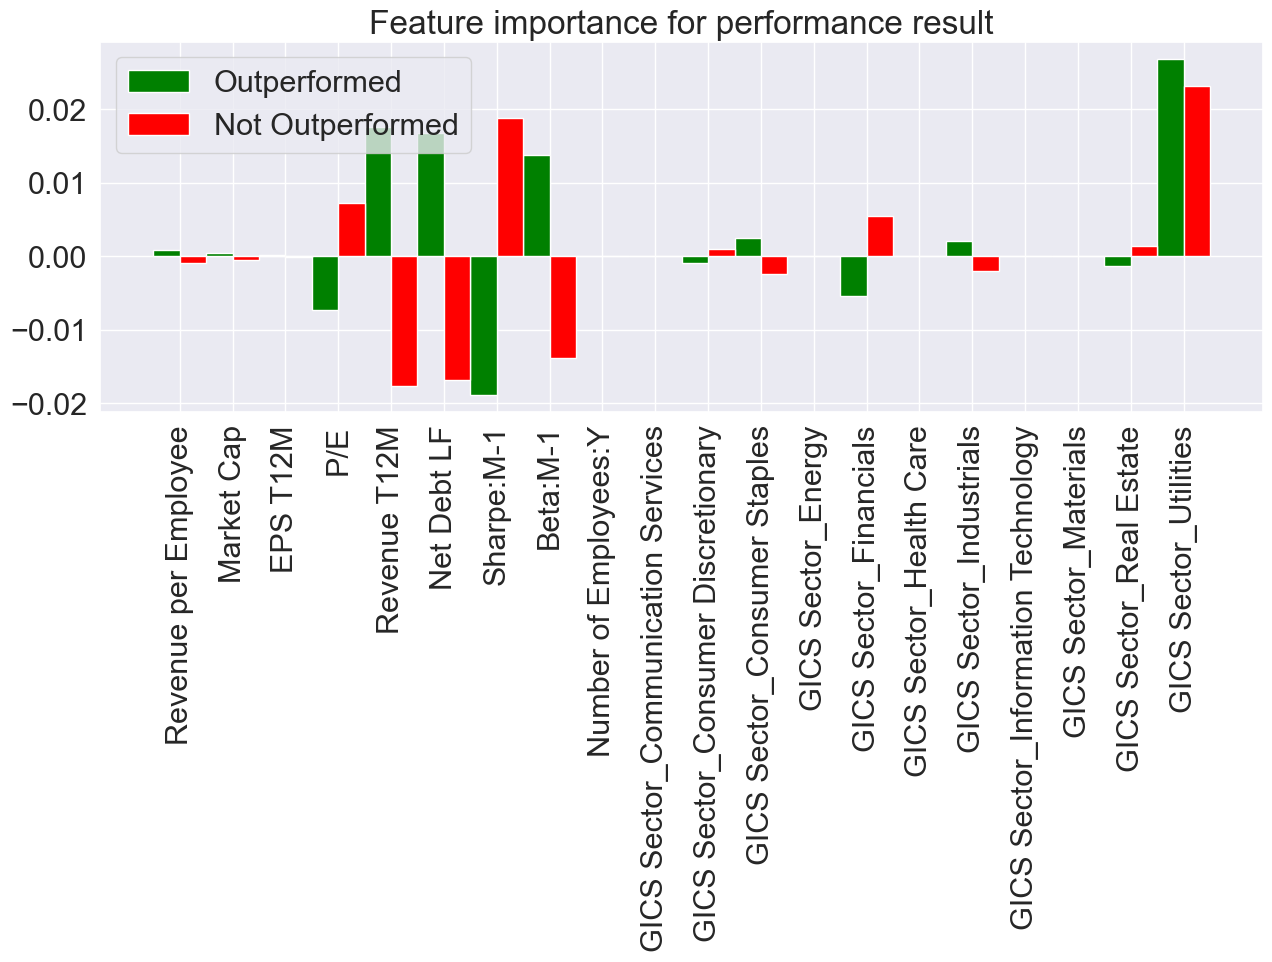

GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [2],
                         'max_features': ['auto'], 'max_leaf_nodes': [500],
                         'min_samples_leaf': [50], 'min_samples_split': [25],
                         'n_estimators': [50]},
             verbose=3)

In [26]:
# current is test
current_is_test_params = params(X_train, y_train)

current_test_Grid = GridSearchCV(
    estimator=rf, param_grid=current_is_test_params, cv=4, verbose=3, n_jobs=-1
)
current_test_Grid.fit(X_train.values, y_train.values)

evaluate(
    current_test_Grid, X_train.values, X_test.values, y_train.values, y_test.values
)

visualize_best("current_test_", current_test_Grid,
               X_train, X_test, y_train, y_test)

CrP.drop(["Compared Performance"], axis=1, inplace=True)

current_test_Grid


Fitting 4 folds for each of 18432 candidates, totalling 73728 fits


c:\Users\lucar\anaconda3\envs\stuffed\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



{'n_estimators': [50], 'max_features': ['auto'], 'max_depth': [9], 'min_samples_leaf': [5], 'min_samples_split': [5], 'max_leaf_nodes': [500], 'bootstrap': [False]}
Fitting 4 folds for each of 1 candidates, totalling 4 fits


c:\Users\lucar\anaconda3\envs\stuffed\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



Train Accuracy : 0.8027656477438136
Train Confusion Matrix:
[[1898  372]
 [ 441 1411]]
Test Accuracy : 0.6179039301310044
Test Confusion Matrix:
[[185  80]
 [ 95  98]]


c:\Users\lucar\anaconda3\envs\stuffed\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



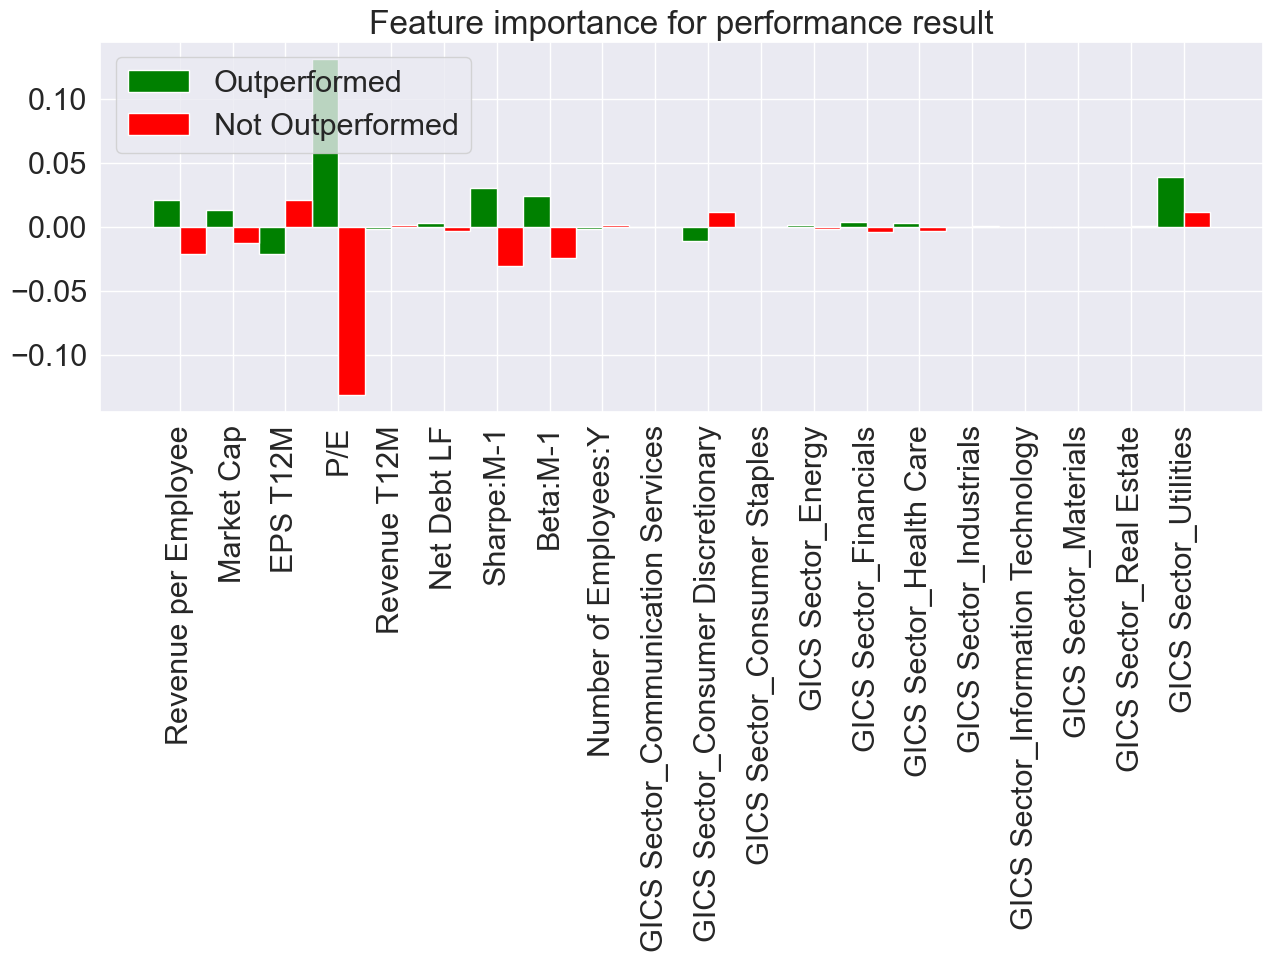

GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [9],
                         'max_features': ['auto'], 'max_leaf_nodes': [500],
                         'min_samples_leaf': [5], 'min_samples_split': [5],
                         'n_estimators': [50]},
             verbose=3)

In [27]:
# all_df
y = all_df["Compared Performance"]
X = all_df.drop(
    columns=["Compared Performance", "Market Cap_perf", "Name", "GICS Sector"]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=222
)

all_params = params(X_train, y_train)

all_Grid = GridSearchCV(
    estimator=rf, param_grid=all_params, cv=4, verbose=3, n_jobs=-1)
all_Grid.fit(X_train.values, y_train.values)

evaluate(all_Grid, X_train.values, X_test.values,
         y_train.values, y_test.values)

visualize_best("all_", all_Grid, X_train, X_test, y_train, y_test)

all_Grid


Fitting 4 folds for each of 18432 candidates, totalling 73728 fits


c:\Users\lucar\anaconda3\envs\stuffed\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



{'n_estimators': [50], 'max_features': ['auto'], 'max_depth': [17], 'min_samples_leaf': [5], 'min_samples_split': [5], 'max_leaf_nodes': [500], 'bootstrap': [True]}
Fitting 4 folds for each of 1 candidates, totalling 4 fits


c:\Users\lucar\anaconda3\envs\stuffed\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



Train Accuracy : 0.9315206445115811
Train Confusion Matrix:
[[1676   33]
 [ 171 1099]]
Test Accuracy : 0.6706948640483383
Test Confusion Matrix:
[[165  47]
 [ 62  57]]


c:\Users\lucar\anaconda3\envs\stuffed\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



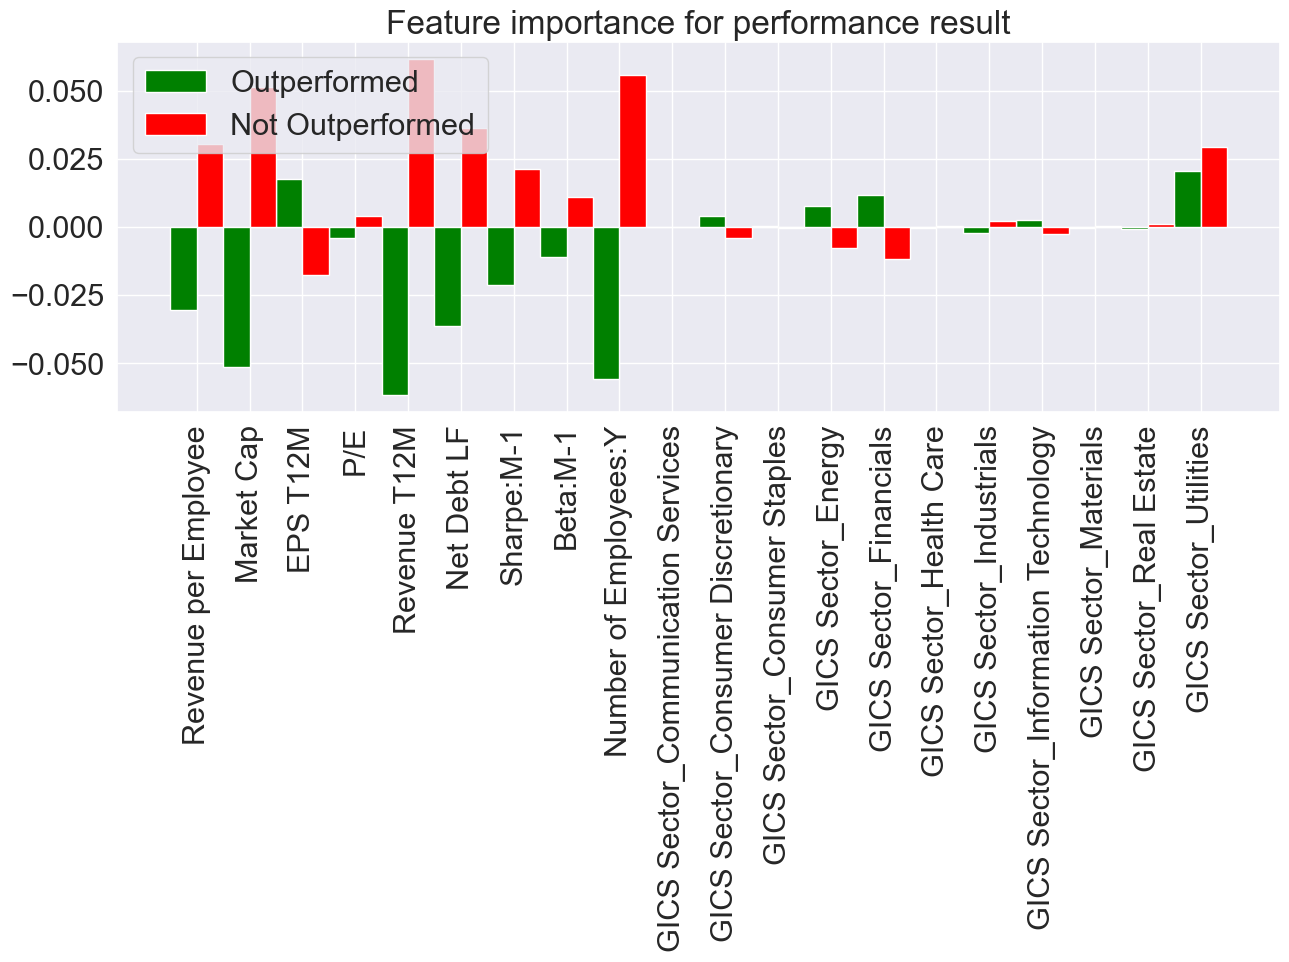

GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [17],
                         'max_features': ['auto'], 'max_leaf_nodes': [500],
                         'min_samples_leaf': [5], 'min_samples_split': [5],
                         'n_estimators': [50]},
             verbose=3)

In [28]:
# concluded_df
y = concluded_df["Compared Performance"]
X = concluded_df.drop(
    columns=["Compared Performance", "Market Cap_perf", "Name", "GICS Sector"]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=222
)

concluded_params = params(X_train, y_train)

concluded_Grid = GridSearchCV(
    estimator=rf, param_grid=concluded_params, cv=4, verbose=3, n_jobs=-1
)
concluded_Grid.fit(X_train.values, y_train.values)

evaluate(concluded_Grid, X_train.values,
         X_test.values, y_train.values, y_test.values)

visualize_best("concluded_", concluded_Grid, X_train, X_test, y_train, y_test)

concluded_Grid


## 3.3 Predictor implementation
COMPARED TO INVESTING INTO THE SP1500 ONLY

Using the findings from above we can determine the companies predicted to outperform

In [29]:
# we add all companies that have been identified as "Outperformed" and assign equal portfolio weights
all_classifier_performance = []
concluded_classifier_performance = []
current_test_classifier_performance = []

# calculating the portfolio performances
for df in all_dfs:
    current_test_outperformed = []
    concluded_outperformed = []
    all_outperformed = []

    compare_df = df.drop(["Market Cap_perf", "Name", "GICS Sector"], axis=1)
    for i in range(df.shape[0]):
        if current_test_Grid.predict([compare_df.iloc[i].values]) == "Outperformed":
            current_test_outperformed.append(df.iloc[i, 0])
        if all_Grid.predict([compare_df.iloc[i].values]) == "Outperformed":
            all_outperformed.append(df.iloc[i, 0])
        if concluded_Grid.predict([compare_df.iloc[i].values]) == "Outperformed":
            concluded_outperformed.append(df.iloc[i, 0])

    print(current_test_outperformed)
    print(all_outperformed)
    print(concluded_outperformed)

    current_test_classifier_performance.append(1 + np.mean(current_test_outperformed))
    all_classifier_performance.append(1 + np.mean(all_outperformed))
    concluded_classifier_performance.append(1 + np.mean(concluded_outperformed))

[0.5021601011182174]
[-0.5414174630173221, 0.11610251740509339, 0.1506381395146691, -0.045177658784108496, 0.13700589878376465, -0.06245373392666296, -0.5242943917359884, 1.6368671160494397, -0.4445325980698409, 0.14080354187486238, 0.2482193468083046, 0.1137348283116921, -0.17786349692068212, -0.23285434772813982, 0.4479053497444085, 2.3444866610105337, 0.5759779856664411, 1.4922006594926192, 0.5088552126082243, 0.20225914491572725, -0.3223220473617356, 0.2976992602286255, 0.1978238936817814, -0.4434762489388159, -0.6872113904478114, 0.9834763778207347, 0.9182991379097157, 0.21209757523786998, -0.2578818568641189, -0.05147067528865498, 0.9248547469124445, 0.7341436150696985, -0.514181007110329, -0.4027423995610414, -0.3249247733423064, -0.42707816479168115, 0.19536196783858029, 0.203147001042724, 0.2491877142308661, 0.7057514429205799, -0.3807508746053108, 0.6019448310473624, 0.2370513660564978, 0.5669679119190111, -0.7237308955544142, -0.5333750873364139, 0.23123840715236918, 0.41439

In [30]:
# importing comparative indices/assets, gold is still saved
sp1500 = yf_import("^SP1500", periods.iloc[0]["Start"], periods.iloc[-1]["Last"])
nasdaq = yf_import("^IXIC", periods.iloc[0]["Start"], periods.iloc[-1]["Last"])
WTI = web.DataReader(
    "WTISPLC", "fred", periods.iloc[0]["Start"], periods.iloc[-1]["Last"]
)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [36]:
performance = periods
gold_performance = []
sp1500_performance = []
nasdaq_performance = []
WTI_performance = []

# creating a data-frame to compare performances of the portfolios with common indices and "crisis" resources
for index, row in periods.iterrows():
    gold_performance.append(
        (
            1
            + ((gold.loc[row["Last"]].values) - (gold.loc[row["Start"]].values))
            / (gold.loc[row["Start"]].values)
        ).item()
    )

    sp1500_performance.append(
        (
            1
            + ((sp1500.loc[row["Last"]].values) - (sp1500.loc[row["Start"]].values))
            / (sp1500.loc[row["Start"]].values)
        ).item()
    )

    nasdaq_performance.append(
        (
            1
            + ((nasdaq.loc[row["Last"]].values) - (nasdaq.loc[row["Start"]].values))
            / (nasdaq.loc[row["Start"]].values)
        ).item()
    )

    WTI_performance.append(
        (
            1
            + ((WTI.loc[row["Last"]].values) - (WTI.loc[row["Start"]].values))
            / (WTI.loc[row["Start"]].values)
        ).item()
    )

In [37]:
performance["Gold"] = gold_performance
performance["Nasdaq"] = nasdaq_performance
performance["Spot Crude Oil Price WTI"] = WTI_performance
performance["S&P 1500"] = sp1500_performance
performance["all_Grid"] = all_classifier_performance
performance["concluded_Grid"] = concluded_classifier_performance
performance["current_test_Grid"] = current_test_classifier_performance
dfi.export(
    performance.style.set_properties(
        **{"background-color": "white", "color": "black", "border-color": "#948b8b"}
    ),
    "performance.png",
)
performance

Name       Start        Last  Duration      Gold    Nasdaq  \
0  Period 1  2004-04-01  2006-08-01        27  1.626804  1.047715   
1  Period 2  2016-09-01  2017-08-01        11  1.000984  1.201220   
2  Period 3  2017-09-01  2018-07-01        10  0.957095  1.206716   
3  Period 4  2022-01-01  2023-04-01        15  1.125556  0.830855   

   Spot Crude Oil Price WTI  S&P 1500  all_Grid  concluded_Grid  \
0                  1.991006  1.148445  1.465244        1.722937   
1                  1.063302  1.135936  1.264555        1.383578   
2                  1.424729  1.124224  1.282267        1.421511   
3                  0.954698  0.900910  1.043568        0.817482   

   current_test_Grid  
0           1.502160  
1           1.159184  
2           1.455724  
3           0.983550